####  OUTLINE

## 1. Load, clean the data and create training, dev, and test sets

## 2. Vectorize the data : W2vec or Countvectorizer or TfidfVectorizer

## 3. Explore the dataset

## 4. Classify with a naïve approach using Sentiwordnet

## 5. Classify with "classic" classifiers

## 6 Quantitative evaluation, first round

## 7. Re Load, clean the data and create training, dev, and test sets

## 8. Classify with DL classifiers

## 9. Quantitative evaluation

## 10. Qualitative evaluation



## 1 Load, clean the data and create training, dev, and test sets

### 1.1 Load the data

**data** from TP2 containing tweets (can be used to train word embedding algo) :

In [1]:
! wget -O tweets.csv https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv
! wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv

--2020-04-12 21:50:30--  https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/plain]
Saving to: ‘tweets.csv’

tweets.csv          100%[===================>]   3.26M  --.-KB/s    in 0.09s   

2020-04-12 21:50:30 (35.0 MB/s) - ‘tweets.csv’ saved [3421431/3421431]

--2020-04-12 21:50:32--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 54.192.160.91, 54.192.160.34, 54.192.160.26, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|54.192.160.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4309577 (4.1M)

In [0]:
import pandas as pd
dfTweets = pd.read_csv('tweets.csv')
df_pol = pd.read_csv('Political-media-DFE.csv', encoding='latin-1')

data from our project :

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/camduf/mlfornlp/master/train.csv")

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [6]:
print(df.text.iloc[0], df.target.iloc[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 1


In [7]:
df=df.drop(['keyword','location','id'],axis=1)
df.shape

(7613, 2)

In [8]:
df=df.dropna(axis=0)
df.shape

(7613, 2)

In [9]:
#the database has "quasi-duplicates" as well (see the cleaning part)
df=df.drop_duplicates()
df.shape

(7521, 2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'samples')

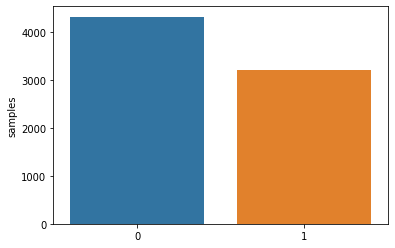

In [10]:
#tweets by category
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
x=df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

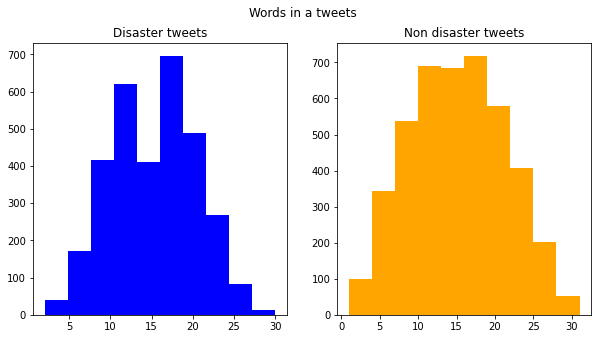

In [11]:
#disastrous teweets seem to be less homogenous in terms of length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
num_words = df[df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(num_words, color='blue')
ax1.set_title('Disaster tweets')

num_words = df[df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(num_words, color='orange')
ax2.set_title('Non disaster tweets')

fig.suptitle('Words in a tweets')
plt.show()

In [12]:
# function to change 0 to irrelevant and 1 to relevant
def transf(x):
    if x==0:
        x="irrelevant"
    elif x==1:
        x="relevant"
    return(x)
df.shape[0]
len(df['text'])

7521

In [13]:
#here we have all the tweets with their category
documents=[]
for i in range(len(df['text'])):
    documents.append((df.text.iloc[0], transf(df.target.iloc[0])))
print(len(documents),type(documents))

7521 <class 'list'>


In [14]:
documents[1]

('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'relevant')

### 1.2 Clean the data

The idea is to transform the raw text (= list of tweets) into a list of tokenized tweets. Generally, tokens will be words, but they also may be meaningful punctuation like emoji. It depends on our cleaning functions. The goal is to decrease computational costs by removing unmeaningful tokens. \\

We face a trade-off between parcimony and relevance. Indeed in the case of tweets, and in the particular case of disaster prediction, capital letters, emotive punctuations ("!" for example) can well be meaningful.

#### 1.2.1 Cleaning step by step


In [15]:
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sn
from string import punctuation, digits 
import re

nltk.download('punkt')
nltk.download('stopwords')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
X=df["text"]
y=df["target"]

In [0]:
#tokenisation
tokenizer = TweetTokenizer()
all_words=[]
all_words = ' '.join(X)
len(all_words)
text_pre= tokenizer.tokenize(all_words)

In [0]:
#at each step, this function shows the effect of the cleaning treatment
def treatment(step):
  text_post=step(text_pre)
  all_words_text_pre=nltk.FreqDist(text_pre)
  all_words_text_post=nltk.FreqDist(text_post)
  all_words_text_post.plot(17)
  print('vocabulary length pre treatment :', len(all_words_text_pre),'vocabulary length post treatment :', len(all_words_text_post))
  print('corpus length pre treatment :', len(text_pre),'corpus length post treatment :', len(text_post))
  return text_post

In [0]:
#lets remove url
def remove_url(tokens):
  #variante
  #url = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)')
  url = re.compile(r'https?://\S+|www\.\S+|#\w+ ?')
  filtered_url=[]
  for words in tokens:
    word=url.sub(r'',words)
    if len(word)>0:
        filtered_url.append(word.lower())    
  return filtered_url

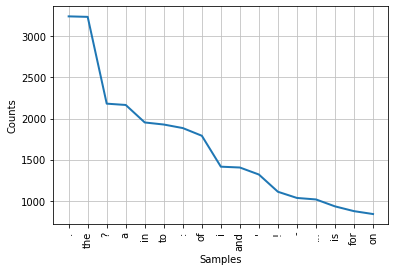

vocabulary length pre treatment : 27329 vocabulary length post treatment : 16681
corpus length pre treatment : 126674 corpus length post treatment : 118771


In [20]:
text_pre=treatment(remove_url)

In [0]:
#translate slang
#inspired from https://github.com/rishabhverma17/sms_slang_translator

import csv
import re

def translator(user_string,slang):
  _str=user_string.lower()
  for index, row in slang.iterrows():
                # Check if selected word matches short forms in text file.
    if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
        user_string = row[1]
    # Return a list of words
  return(user_string.split(" "))

In [0]:
from itertools import chain
def trans_slang(tokens):
  url = "https://raw.githubusercontent.com/camduf/mlfornlp/master/slang.txt"
  slang=pd.read_csv(url, delimiter="=",header=None)
  tokens =list(chain.from_iterable(translator(item,slang) for item in tokens))
  return list(tokens)

In [0]:
#text_pre=treatment(trans_slang)
#works well but takes a long time

In [0]:
#lets remove stop words
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
def remove_stopwords(tokens):
  filtered_sentence=[]
  for w in tokens:
      if w.lower() not in stop_words:
          filtered_sentence.append(w)  
  return filtered_sentence

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


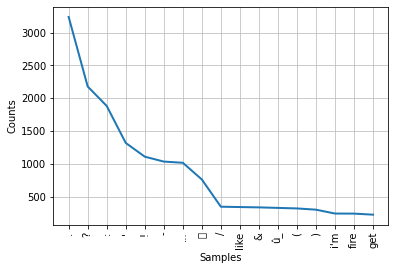

vocabulary length pre treatment : 16681 vocabulary length post treatment : 16520
corpus length pre treatment : 118771 corpus length post treatment : 83352


In [25]:
text_pre=treatment(remove_stopwords)

In [0]:
#lets remove punctuation (digits are in this category)
def remove_punctuation(tokens):
  pct=re.compile(r'[-.,?!:;()|0-9]')
  post_punctuation=[]
  for words in tokens:
      word=pct.sub("",words)
      if len(word)>0:
          post_punctuation.append(word)
  return post_punctuation

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


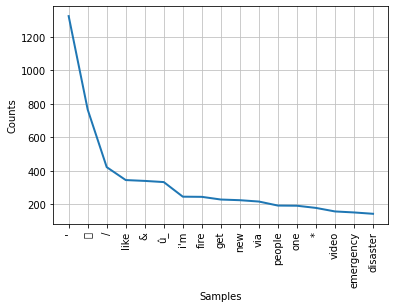

vocabulary length pre treatment : 16520 vocabulary length post treatment : 15651
corpus length pre treatment : 83352 corpus length post treatment : 69668


In [27]:
text_pre=treatment(remove_punctuation)

In [0]:
#lets remove web signs
def remove_signs_web(tokens):
  sign=re.compile(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)')
  post_sign=[]
  for words in tokens:
      word=sign.sub("",words)
      if len(word)>0:
          post_sign.append(word)
  return post_sign

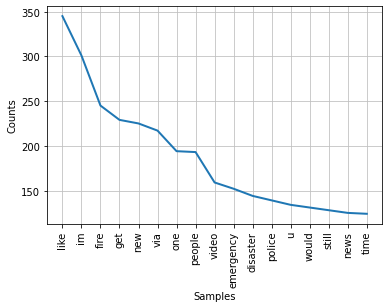

vocabulary length pre treatment : 15651 vocabulary length post treatment : 13369
corpus length pre treatment : 69668 corpus length post treatment : 62782


In [29]:
text_pre=treatment(remove_signs_web)

In [0]:
#lets remove emoji
def remove_emoji(tokens):
  emoji = re.compile("["u"\U0001F600-\U0001F64F"u"\U0001F300-\U0001F5FF"u"\U0001F680-\U0001F6FF"u"\U0001F1E0-\U0001F1FF"u"\U00002702-\U000027B0"u"\U000024C2-\U0001F251""]+", flags=re.UNICODE)
  filtered_emoji=[]
  for words in tokens:
      word=emoji.sub(r'',words)
      if len(word)>0:
          filtered_emoji.append(word)
  return filtered_emoji

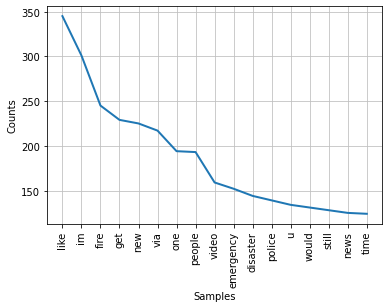

vocabulary length pre treatment : 13369 vocabulary length post treatment : 13369
corpus length pre treatment : 62782 corpus length post treatment : 62782


In [31]:
text_pre=treatment(remove_emoji)

In [0]:
#lets remove indiv alphabet
def remove_indiv_alpha(tokens):
  post_indiv=[]
  for words in tokens:
      if len(words)!=1:
          post_indiv.append(words)
  return post_indiv

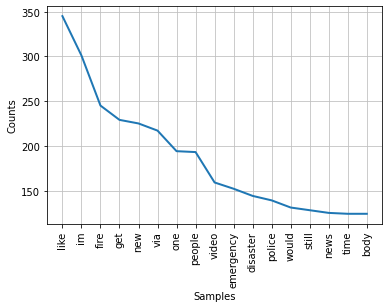

vocabulary length pre treatment : 13369 vocabulary length post treatment : 13343
corpus length pre treatment : 62782 corpus length post treatment : 61941


In [33]:
text_pre=treatment(remove_indiv_alpha)

In [34]:
nltk.download('wordnet')
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer

#lets do stemming
##stemming+lowercase
def stemming(tokens):
  post_stem=[]
  word_lem=WordNetLemmatizer()
  for word in tokens:
      post_stem.append(word_lem.lemmatize(word).lower())
  return post_stem

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


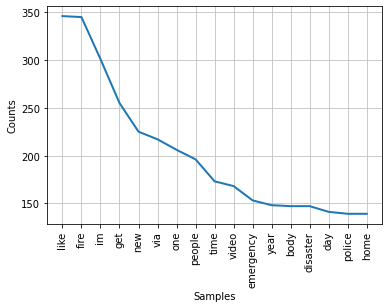

vocabulary length pre treatment : 13343 vocabulary length post treatment : 12086
corpus length pre treatment : 61941 corpus length post treatment : 61941


In [35]:
text_pre=treatment(stemming)

In [36]:
#we take the first 5000 as features
all_words=nltk.FreqDist(text_pre)
word_features= list(all_words.keys())[:5000]
word_features

['deed',
 'reason',
 'may',
 'allah',
 'forgive',
 'u',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask',
 'canada',
 'resident',
 'asked',
 'shelter',
 'place',
 'notified',
 'officer',
 'evacuation',
 'order',
 'expected',
 'people',
 'receive',
 'california',
 'got',
 'sent',
 'photo',
 'ruby',
 'smoke',
 'pours',
 'school',
 'update',
 'hwy',
 'closed',
 'direction',
 'due',
 'lake',
 'county',
 'heavy',
 'rain',
 'cause',
 'flash',
 'flooding',
 'street',
 'manitou',
 'colorado',
 'spring',
 'area',
 'im',
 'top',
 'hill',
 'see',
 'wood',
 'there',
 'emergency',
 'happening',
 'building',
 'across',
 'afraid',
 'tornado',
 'coming',
 'three',
 'died',
 'heat',
 'wave',
 'far',
 'haha',
 'south',
 'tampa',
 'getting',
 'flooded',
 'hah',
 'wait',
 'second',
 'live',
 'gonna',
 'fvck',
 'day',
 'ive',
 'lost',
 'count',
 'bago',
 'myanmar',
 'arrived',
 'damage',
 'bus',
 'multi',
 'car',
 'crash',
 'whats',
 'man',
 'love',
 'fruit',
 'summer',
 'lovely',
 'fast',
 'goooooooa

In [0]:
import random 
from nltk.tokenize import word_tokenize
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
word_lem=WordNetLemmatizer()
#find features
def find_features(document):
    tokenizer = TweetTokenizer()
    words=[]
    words1=tokenizer.tokenize(document)
    for word in words1:
        words.append(word_lem.lemmatize(word).lower())
    features={}
    for w in word_features:
        features[w]=(w in words)
    return features

featuresets = [(find_features(rev),category) for (rev,category) in documents]

In [38]:
pd.Series(featuresets[8][0]).value_counts()

False    4994
True        6
dtype: int64

#### 1.2.2 Cleaning all steps in one function

In [39]:
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sn
from string import punctuation
from string import digits

nltk.download('punkt')
nltk.download('stopwords')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
en_stop = list(set(nltk.corpus.stopwords.words('english')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from tqdm import tqdm
#function to tokenize and to clean
#order of tokenization and cleaning matters

def tokenize_url_hashtags_4tweets(corpus):

  tokenizer = TweetTokenizer() 
  
  tokenized_tweets = []
  for sample in tqdm(corpus):
    #sample is a tweet
    tokens = tokenizer.tokenize(sample)
    #tokens is a list of tokens corresponding to a tweet

    ## variants activating one or/and another of these lines :
    #tokens = list(map(lambda x: x.lower(), tokens)) 
    #tokens = trans_slang(tokens)
    tokens = list(map(lambda x: x.lower(), tokens)) 
    tokens = remove_url(tokens)
    tokens = remove_signs_web(tokens)
    tokens = remove_emoji(tokens)
    tokens = remove_punctuation(tokens)
    tokens = stemming(tokens)
    tokens = remove_stopwords(tokens)
    tokens = remove_indiv_alpha(tokens)
    tokenized_tweets.append(tokens)
  return tokenized_tweets

100%|██████████| 7521/7521 [00:01<00:00, 5773.74it/s]


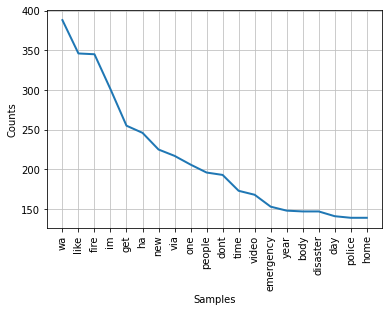

Text length of X_cleaned :  62599 Vocabulary length of X_cleaned :  12049


In [41]:
X_cleaned = tokenize_url_hashtags_4tweets(X.array)
# X_cleaned is a list of lists of tokens
flatten = lambda l: [item for sublist in l for item in sublist]
X_cl_flat=flatten(X_cleaned)
# X_cl_flat is a list of tokens
all_words=nltk.FreqDist(X_cl_flat)
all_words.plot(20)
print('Text length of X_cleaned : ',len(X_cl_flat),'Vocabulary length of X_cleaned : ',len(all_words))

In [42]:
#to get the vocabulary of X_cleaned
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features 
get_word_features(X_cl_flat)

dict_keys(['deed', 'reason', 'may', 'allah', 'forgive', 'forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada', 'resident', 'asked', 'shelter', 'place', 'notified', 'officer', 'evacuation', 'order', 'expected', 'people', 'receive', 'california', 'got', 'sent', 'photo', 'ruby', 'smoke', 'pours', 'school', 'update', 'hwy', 'closed', 'direction', 'due', 'lake', 'county', 'heavy', 'rain', 'cause', 'flash', 'flooding', 'street', 'manitou', 'colorado', 'spring', 'area', 'im', 'top', 'hill', 'see', 'wood', 'emergency', 'happening', 'building', 'across', 'afraid', 'tornado', 'coming', 'three', 'died', 'heat', 'wave', 'far', 'haha', 'south', 'tampa', 'getting', 'flooded', 'hah', 'wait', 'second', 'live', 'gonna', 'fvck', 'day', 'ive', 'lost', 'count', 'bago', 'myanmar', 'arrived', 'damage', 'bus', 'multi', 'car', 'crash', 'whats', 'man', 'love', 'fruit', 'summer', 'lovely', 'fast', 'goooooooaaaaaal', 'ridiculous', 'london', 'cool', 'skiing', 'wonderful', 'looooool', 'way', 'cant', 'eat', 'sh

In [43]:
X_cleaned = [' '.join(x) for x in X_cleaned]
#X_cleaned is a list of cleaned tweets
print('--------------Cleaned tweets-------------')
print(len(X_cleaned), X_cleaned[0:15], type(X_cleaned))
print('--------------Tweets before cleaning-------------')
print(len(X.array), X.array[0:15])

--------------Cleaned tweets-------------
7521 ['deed reason may allah forgive', 'forest fire near la ronge sask canada', 'resident asked shelter place notified officer evacuation shelter place order expected', 'people receive evacuation order california', 'got sent photo ruby smoke pours school', 'update california hwy closed direction due lake county fire', 'heavy rain cause flash flooding street manitou colorado spring area', 'im top hill see fire wood', 'emergency evacuation happening building across street', 'im afraid tornado coming area', 'three people died heat wave far', 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck', 'day ive lost count', 'bago myanmar arrived bago', 'damage school bus multi car crash'] <class 'list'>
--------------Tweets before cleaning-------------
7521 <PandasArray>
[                                                                'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
                 

In [44]:
X_cleaned[5639]
#this tweet is one of the "quasi-duplicates" evoked earlier

'video picking body water rescuer searching hundred migrant mediterran'

In [45]:
XXy_cleaned=np.vstack((X,X_cleaned,y)).T
XXy_cleaned.shape

(7521, 3)

In [46]:
#here we want to get rid of "quasi-duplicates" thanks to the cleaning function
df_dup=pd.DataFrame(XXy_cleaned)
df_dup.columns=['text','text_cleaned','target']
df_dup['text_cleaned_tr'] = df_dup['text_cleaned'].str[:25]
df_dup.head()
#the threshold 25 enables to get rid of the twin tweet 'video picking body water rescuer searching hundred migrant mediterran'
#other "quasi-duplicates" may remain though

,text,text_cleaned,target,text_cleaned_tr
0,Our Deeds are the Reason of this #earthquake M...,deed reason may allah forgive,1,deed reason may allah for
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1,forest fire near la ronge
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,1,resident asked shelter pl
3,"13,000 people receive #wildfires evacuation or...",people receive evacuation order california,1,people receive evacuation
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby smoke pours school,1,got sent photo ruby smoke


In [47]:
df_ssdup=df_dup.drop_duplicates(subset=['text_cleaned_tr','target'])
df_ssdup.shape

(6530, 4)

In [0]:
#to check if the tweet is still repeated
l_idx=[]
for index, row in df_ssdup.iterrows():
  if 'body' in row['text_cleaned_tr']:
    l_idx.append(index)

In [0]:
X=df_ssdup["text"]
y=df_ssdup["target"]
#X and y are not cleaned yet, they are just without "quasi-duplicates"
#But our cleaning function is ready to be applied just after

### 1.3 Create training, dev and test sets

As advised in TP, we slit the dataset into 3 sets:
- Training set: **60%**: used to train the classifier and obtain a model
- Dev set: **20%**: used to apply the model and check performance while tuning it
- Test set: **20%** used as the final performance check to see if the generalization is ok

Suggested convenient class: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [0]:
from sklearn.model_selection import train_test_split
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)

In [51]:
print(X_train.shape,y_train.shape)
print(X_train.head(),y_train.head())

(3918,) (3918,)
3928    Residents in the central part of Ocean City he...
2841                           The Drought Is Real ??????
4945    'It looks like a mudslide!' And #GBBO is back ...
3646    I added a video to a @YouTube playlist http://...
6652    A STRONG THUNDERSTORM WILL AFFECT CENTRAL HALI...
Name: text, dtype: object 3928    1
2841    1
4945    1
3646    0
6652    1
Name: target, dtype: object


In [52]:
# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)
print(X_dev.shape,y_dev.shape)
print(X_dev.head(),y_dev.head())

(1306,) (1306,)
2254    Enugu Government to demolish illegal structure...
5861    i'm sorry i'm so wild in 1d shows like in my w...
6217    TodayÛªs storm will pass; let tomorrowÛªs li...
3991    Q: Why do ducks have big flat feet? A: To stam...
7223       Wild fires freak me the fuck out. Like hell no
Name: text, dtype: object 2254    0
5861    0
6217    1
3991    0
7223    1
Name: target, dtype: object


In [53]:
# we apply our cleaning function to all the datasets
X_train_cleaned = tokenize_url_hashtags_4tweets(X_train.array)
X_train_cleaned = [' '.join(x) for x in X_train_cleaned]
X_dev_cleaned = tokenize_url_hashtags_4tweets(X_dev.array)
X_dev_cleaned = [' '.join(x) for x in X_dev_cleaned]
X_test_cleaned = tokenize_url_hashtags_4tweets(X_test.array)
X_test_cleaned = [' '.join(x) for x in X_test_cleaned]
#these are the cleaned databases that we will use after
#with countvectorizer or tfidf veectorizer, we may use raw data because they offer cleaning options

100%|██████████| 1306/1306 [00:00<00:00, 5753.61it/s]


In [0]:
y_train=y_train.tolist()
y_dev=y_dev.tolist()
y_test=y_test.tolist()

## 2 Vectorize the data : w2vec or Countvectorizer

### 2.1 W2vec

on this model, each word is represented as vector of number and each number correspond to specific context where the relation between different words is preserved.we can creat this model out of a huge corpus and to creat an efficient word2vec model we need lot of data. Then we have to create a matrix with all the unique words in the dataset, the matrix represents the occurence relation between the words,it preserved the semantic relation based on the association of words(which words appear together).

#### 2.1.1 W2vec trained on an external database

We will try first to train W2vec on an external database (a base of tweets used in TP).

In [55]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

#df_pol is cleaned
cleaned_pol = tokenize_url_hashtags_4tweets(df_pol.text.array)

#W2Vec is trained on this dataset
pol = Word2Vec(cleaned_pol, size=100, window=5, min_count=3, workers=cpu)
pol.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=10)
pol_wv = pol.wv

 21%|██        | 1043/5000 [00:00<00:00, 5203.91it/s]

The virtual instance has 4 cpus, that will be used to train the word2vec model


100%|██████████| 5000/5000 [00:01<00:00, 2887.87it/s]


In [0]:
# Create a function to transform the corpus into an embedding one
def tokens2vectors(tokenCorpus):
  ''' transforms our X into a list of list of vec (2D array) '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
    #un token est un mot
      try: tweetVecs.append(pol_wv.get_vector(token)  )
      except: tweetVecs.append( np.zeros(100) ) 
    #chaque tweet a pour représentation vectorielle la moyenne des représentations vectorielles des tokens (ou mots) le composant
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)

X_train_wvpol = tokens2vectors(X_train_cleaned)
X_dev_wvpol = tokens2vectors(X_dev_cleaned)
X_test_wvpol = tokens2vectors(X_test_cleaned)


In [57]:
X_train_wvpol.shape

(3918, 100)

#### 2.1.2 W2vec trained on our database

In [58]:
X_train_cleaned_wv = tokenize_url_hashtags_4tweets(X_train.array)
wvdf = Word2Vec(X_train_cleaned_wv, size=100, window=5, min_count=3, workers=cpu)
wvdf.train(X_train_cleaned_wv, total_examples=len(X_train_cleaned_wv), epochs=10)
df_wv = wvdf.wv

100%|██████████| 3918/3918 [00:00<00:00, 5781.18it/s]


In [0]:
# Create a function to transform the corpus into an embedding one
def tokens2vectors(tokenCorpus):
  ''' transforms our X into a list of list of vec (2D array) '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
      try: tweetVecs.append(df_wv.get_vector(token)  )
      except: tweetVecs.append( np.zeros(100) ) 
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)

X_train_wvdf = tokens2vectors(X_train_cleaned)
X_dev_wvdf = tokens2vectors(X_dev_cleaned)
X_test_wvdf = tokens2vectors(X_test_cleaned)

### 2.2 Bag of words vectorizers

#### 2.2.1 Countvectorizer

Use the CountVectorizer (bag of words and their occurrence counts in a sparse matrix).

Processing Text (X)

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk.sentiment.util import extract_unigram_feats, mark_negation
cv = CountVectorizer(stop_words=['http','https','www','url','co'], min_df=0.001)
#15221
#variantes essayées (cf. sous-paragraphe cross validation) :
#cv = CountVectorizer(min_df=0.001)
#1908
#cv = CountVectorizer(ngram_range=(1, 2))
#59785
#cv = CountVectorizer(tokenizer=lambda text: mark_negation(word_tokenize(text)))
#17421
#cv = CountVectorizer(stop_words=en_stop)
#15084
#cv = CountVectorizer(lowercase=False)
#18124
#le param par défaut : cv = CountVectorizer(token_pattern=(?u)\b\w\w+\b)
#keep ! and ? and " and '
#cv = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")
#15224
#remove digits
#cv = CountVectorizer(token_pattern=r'\b[^\d\W]+\b')
#
#cv = CountVectorizer(stop_words=['http','https','www','url','co'])
#15218
X_train_cv = cv.fit_transform(X_train)
print(X_train_wvdf.shape, X_train_wvpol.shape, X_train_cv.shape)

(3918, 100) (3918, 100) (3918, 1972)


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [61]:
# pour analyser la liste des n plus fréquents mots (essayer Freqdist de nltk)
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = cv.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
get_top_n_words(X_train, n=30)

[('the', 1736),
 ('to', 1040),
 ('in', 969),
 ('of', 950),
 ('and', 807),
 ('is', 521),
 ('you', 520),
 ('it', 464),
 ('on', 460),
 ('for', 453),
 ('that', 384),
 ('my', 380),
 ('with', 294),
 ('this', 279),
 ('at', 264),
 ('be', 236),
 ('from', 217),
 ('by', 217),
 ('have', 212),
 ('are', 209),
 ('was', 205),
 ('just', 204),
 ('like', 203),
 ('me', 196),
 ('but', 194),
 ('so', 191),
 ('amp', 187),
 ('your', 181),
 ('up', 176),
 ('û_', 172)]

In [62]:
X_train_cv[1,:]

<1x1972 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [63]:
# for dev set
X_dev_cv = cv.transform(X_dev)
X_dev_cv.shape

(1306, 1972)

In [64]:
# for test set
X_test_cv = cv.transform(X_test)
X_test_cv.shape

(1306, 1972)

#### 2.2.2 TFiDF

Use the TfidfVectorizer (bag of words and their word frequency scores in a matrix). \\
TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a tweet but not across tweets. \\
TF-IDF = Term Frequency x Inverse Document Frequency

In [0]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(min_df=3)   
X_train_tv = tv.fit_transform(X_train)

N-gram modelling_word grams : 

another modeling technique which is completely different from the tf-idf or the bag of words model, here we are considering words to be the states of the Markov chains. we define all the different words that follow a specific ngram and we can have more than one word following the same ngram so we have a list of words that are following the same ngram.here how we are going to use this type of information to do our classification. we need to convert our tweets into one of the models the Bag of Words or TFIDF model and while building the models we also have take care of n-grams which might increase accuracy. In Python, TfidfVectorizer is used to convert a list of text into TFIDF model and it has a property called ngram_range which can be set to 2 or more for taking care of ngrams. 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
TV_Ngram = TfidfVectorizer(min_df=3,ngram_range=(1,5))   
X_train_tv_Ngram = TV_Ngram.fit_transform(X_train)

the 2 models above have some problems:<br/>1.the semantic information of the words is not stored. Even in TF-IDF model we only give more importance to the uncommon words. when we are working with those 2 models we care about the words individually whether a particular word appears or whether the particular word does not appear but we don't care about which words appear together or what is the probability is some words appeared then another word has to appear or something like that so to get over with that problem we have the word2vec model 
<br/>2.there is a chance of overfitting. 

## 3 Explore the dataset

How both groups of tweets (disastrous and non-disastrous) can be represented ?

In [68]:
# top n words ventilée par la variable target
def get_top_n_words_by_cat(corpus,y, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = cv.fit(corpus)
    bag_of_words = vec.transform(corpus)
    subset_0 = bag_of_words [[idx for idx,e in enumerate(y) if e == 0]]
    sum_words_0 = subset_0.sum(axis=0) 
    subset_1 = bag_of_words [[idx for idx,e in enumerate(y) if e == 1]]
    sum_words_1 = subset_1.sum(axis=0) 
    words_freq = [(word, sum_words_0[0, idx], sum_words_1[0, idx],sum_words_0[0, idx]+ sum_words_1[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[3], reverse=True)
    return words_freq[:n]
liste_30top=get_top_n_words_by_cat(X_train,y_train, n=30)
column_names=['word','freq_target1','freq_target0','freq_tot']
liste_30top = pd.DataFrame(liste_30top, columns=column_names)
print(liste_30top)
liste_30top.to_csv('liste_30top.csv', mode='a', index=True, sep='&',line_terminator=' \\\\\n')

##on pourrait comparer au score sentiwordnet

    word  freq_target1  freq_target0  freq_tot
0    the          1100           636      1736
1     to           681           359      1040
2     in           461           508       969
3     of           510           440       950
4    and           555           252       807
5     is           343           178       521
6    you           449            71       520
7     it           329           135       464
8     on           259           201       460
9    for           283           170       453
10  that           258           126       384
11    my           315            65       380
12  with           211            83       294
13  this           184            95       279
14    at           125           139       264
15    be           176            60       236
16  from           108           109       217
17    by           138            79       217
18  have           145            67       212
19   are           128            81       209
20   was     

In [69]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate=100.0, early_exaggeration=2., n_iter=250)
X_tsne = tsne.fit_transform(X_train_wvpol)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3918 samples in 0.035s...
[t-SNE] Computed neighbors for 3918 samples in 1.806s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3918
[t-SNE] Computed conditional probabilities for sample 2000 / 3918
[t-SNE] Computed conditional probabilities for sample 3000 / 3918
[t-SNE] Computed conditional probabilities for sample 3918 / 3918
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 5.623238
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


In [70]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

mapColors = {0:'lightseagreen', 1:'blueviolet'}
mapSentColors = {0:'lightseagreen', 1:'blueviolet'}
colorsSentiment = [mapSentColors[s] for s in df.target]

fig_senti = go.Figure(data=go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    hovertext = list(zip(df.loc[:, "text"], df.target)),
    mode='markers+text',
    marker=dict(
        size=4,
        color=colorsSentiment,
        colorscale='Viridis',
        showscale=True,
    )
))
fig_senti.update_layout(
    title="Tweets relevant/irrelevant (W2V embedding on an external database)"
)
fig_senti.show()
#Relevant/irrelevant tweets are not well grouped with their W2vec trained on df_pol vectorial representation

In [71]:
ms=pol_wv.most_similar('disaster')
ms[:10]

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('contract', 0.9976783394813538),
 ('giving', 0.9976372122764587),
 ('produce', 0.9975927472114563),
 ('certainly', 0.9975539445877075),
 ('equally', 0.9975276589393616),
 ('recovery', 0.9974970817565918),
 ('budgeting', 0.9974418878555298),
 ('basic', 0.9973797798156738),
 ('choose', 0.9972898960113525),
 ('prohibiting', 0.9972860813140869)]

In [72]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate=100.0, early_exaggeration=2., n_iter=250)
X_tsne = tsne.fit_transform(X_train_wvdf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3918 samples in 0.056s...
[t-SNE] Computed neighbors for 3918 samples in 0.510s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3918
[t-SNE] Computed conditional probabilities for sample 2000 / 3918
[t-SNE] Computed conditional probabilities for sample 3000 / 3918
[t-SNE] Computed conditional probabilities for sample 3918 / 3918
[t-SNE] Mean sigma: 0.010010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 3.882748
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


In [73]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

mapColors = {0:'lightseagreen', 1:'blueviolet'}
mapSentColors = {0:'lightseagreen', 1:'blueviolet'}
colorsSentiment = [mapSentColors[s] for s in df.target]

fig_senti = go.Figure(data=go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    hovertext = list(zip(df.loc[:, "text"], df.target)),
    mode='markers+text',
    marker=dict(
        size=4,
        color=colorsSentiment,
        colorscale='Viridis',
        showscale=True,
    )
))
fig_senti.update_layout(
    title="Tweets relevant/irrelevant (W2V embedding on our database)"
)
fig_senti.show()



In [74]:
ms=df_wv.most_similar('disaster')
ms[:10]
#this list of words is more explicit, maybe because alarmist tweets are better reprensented in our database
#we expect that Word2vec trained on our base is more performant

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('weapon', 0.9996439814567566),
 ('reactor', 0.9996311068534851),
 ('happened', 0.9996063709259033),
 ('never', 0.999594509601593),
 ('would', 0.9995788335800171),
 ('air', 0.9995695352554321),
 ('power', 0.999556303024292),
 ('family', 0.9995542168617249),
 ('change', 0.9995530247688293),
 ('deluge', 0.9995529651641846)]

## 4 Classify with a naïve approach using Sentiwordnet

code from https://nlpforhackers.io/sentiment-analysis-intro/

Each token (=word) in a specific context has a "positive" score and a "negative score" according to sentiwordnet. Each tweet has a score which is the sum of all its words' positive and negative scores.

The idea is to say that predicting a disaster has something to do with sentiment analysis. More positive tweets may be irrelevant and more negative ones may be relevant.

Two possibilities to classify: or you take each tweet's raw score and y_pred=1 if and only if the tweet's score is positive or you train a classic classifier on the only feature which is the tweets' score.

In [75]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag 
lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
def swn_polarity(text):
    """
    Return a sentiment polarity: 0 = negative, 1 = positive
    """
 
    sentiment = 0.0
    tokens_count = 0
 
    raw_sentences = sent_tokenize(text)
    #print(raw_sentences)

    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        #print(tagged_sentence)

        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            #print(wn_tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
 
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
    
    # judgment call ? Default to positive or negative
    if not tokens_count:
        return 0
 
    # sum greater than 0 => positive sentiment
    if sentiment >= 0:
        return 1
 
    # negative sentiment
    return 0

 
def swn_senti(text):
    """
    Return a sentiment score
    """
 
    sentiment = 0.0
    tokens_count = 0
 
    raw_sentences = sent_tokenize(text)
    #print(raw_sentences)

    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        #print(tagged_sentence)

        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            #print(wn_tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
 
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1

    return sentiment
 
print (swn_senti(X_train_cleaned[1]))
 
print (swn_polarity(X_train_cleaned[1]), y_train[1]) #1 1

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
0.125
1 1


In [76]:
y_pred_senti = [swn_polarity(text) for text in X_dev_cleaned ]
X_sentiment = np.array([swn_senti(text) for text in X_dev_cleaned ])
print (accuracy_score(y_dev, y_pred_senti),recall_score(y_dev, y_pred_senti)) # perf très médiocre, accuracy de moins de 50%

0.47166921898928027 0.6029411764705882


In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#version logit
clf = LogisticRegression().fit(X_sentiment.reshape(-1,1), y_dev)
y_pred_senti_logit=clf.predict(X_sentiment.reshape(-1,1))
print (accuracy_score(y_dev, y_pred_senti_logit),recall_score(y_dev, y_pred_senti_logit))
#the model is not so bad in terms of accuracy but not in terms of recall

0.5819295558958653 0.027573529411764705


## 5 Classify with "classic" classifiers

Now that we extracted very basic features from our tweets, we try to apply a simple classifier to predict for each tweet if it is relevant (target=1) ou irrelevant (target=0). 

We will use cross validation to get the optimal parameters both for vectorization and for classification.
Cross Validation is possible through the definition of pipelines.

To limit the nb of variants, we will use WVdf and Countvectorizer in the following (our tests show that they are the most performants).

### 5.1 Pipeline W2V + classic classifiers







First : W2Vec + classifier

code from https://living-sun.com/fr/scikit-learn/784509-pipelline-and-gridsearch-for-doc2vec-scikit-learn-pipeline-gensim-grid-search.html

We tried many other classifiers with W2Vec but random forest was the most performant.

####5.3.2 WVpol + RFC

In [0]:
import sys
import os
from time import time
from operator import itemgetter
import pickle
from argparse import ArgumentParser
from sklearn.svm import LinearSVC

from gensim.models.doc2vec import TaggedDocument
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator
from gensim import corpora

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

class Word2VecModel_wvpol(BaseEstimator):

    def __init__(self, dm=1, size=1, window=1):
        self.w2v_model = None
        self.size = size
        self.window = window

    def fit(self, raw_documents, y=None):
        # Initialize model
        self.w2v_model = Word2Vec(size=self.size, window=self.window,  iter=5, alpha=0.025, min_alpha=0.001)
        cleaned_pol = tokenize_url_hashtags_4tweets(df_pol.text.array)
        self.w2v_model.build_vocab(cleaned_pol)
        # Train model
        self.w2v_model.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=self.w2v_model.iter)
        return self
    

    def transform(self, raw_documents):
        X = []
        for index, row in raw_documents.iteritems():
          tweetVecs = list()
          for token in row.split(' '):
            #un token est un mo
            try: tweetVecs.append(self.w2v_model.wv.get_vector(token) )
            except: tweetVecs.append( np.zeros(self.size) ) 
              #chaque tweet a pour représentation vectorielle la moyenne des représentations vectorielles des tokens (ou mots) le composant
          X.append(np.mean(tweetVecs, axis=0))
        X = pd.DataFrame(X, index=raw_documents.index)
        return X

    def fit_transform(self, raw_documents, y=None):
        self.fit(raw_documents)
        return self.transform(raw_documents)


In [79]:
##CV takes a lot of time so we apply selected parameters directly
param_grid = {#'w2vec_wvpol__window': [3,5,10,20],
              #'w2vec__dm': [0,1],
              #'w2vec_wvpol__size': [30,50,100,200,300],
              #'log__C': [0.1, 1],
}

pipe_log = Pipeline([('w2vec_wvpol', Word2VecModel_wvpol(size=30,window=3)), 
                     ('clf', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1))])

log_grid = GridSearchCV(pipe_log, 
                        param_grid=param_grid,
                        scoring="accuracy",
                        verbose=3,
                        n_jobs=1)

fitted = log_grid.fit(pd.Series(X_train_cleaned),y_train)
y_pred_wvpol_rfc = fitted.predict(pd.Series(X_dev_cleaned))


# Best parameters
print("Best Parameters: {}\n".format(log_grid.best_params_))
print("Best accuracy: {}\n".format(log_grid.best_score_))
print("Finished.")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

 10%|█         | 515/5000 [00:00<00:00, 5146.34it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


100%|██████████| 5000/5000 [00:01<00:00, 2871.08it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it

[CV] .................................... , score=0.579, total=   6.6s
[CV]  ................................................................


100%|██████████| 5000/5000 [00:01<00:00, 2925.04it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it

[CV] .................................... , score=0.605, total=   5.5s
[CV]  ................................................................


100%|██████████| 5000/5000 [00:01<00:00, 2922.56it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

 10%|█         | 521/5000 [00:00<00:00, 5201.35it/s]

[CV] .................................... , score=0.573, total=   5.4s
[CV]  ................................................................


100%|██████████| 5000/5000 [00:01<00:00, 2872.45it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

 10%|█         | 524/5000 [00:00<00:00, 5236.90it/s]

[CV] .................................... , score=0.604, total=   5.5s
[CV]  ................................................................


100%|██████████| 5000/5000 [00:01<00:00, 2921.22it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would ret

[CV] .................................... , score=0.577, total=   5.3s


100%|██████████| 5000/5000 [00:01<00:00, 2864.52it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Best Parameters: {}

Best accuracy: 0.5875462637162144

Finished.


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


####5.3.2 WVdf + RFC

In [0]:
class Word2VecModel_wvdf(BaseEstimator):

    def __init__(self, dm=1, size=1, window=1):
        self.w2v_model = None
        self.size = size
        self.window = window

    def fit(self, raw_documents, y=None):
        # Initialize model
        self.w2v_model = Word2Vec(size=self.size, window=self.window,  iter=5, alpha=0.025, min_alpha=0.001)
        X_train_cleaned = tokenize_url_hashtags_4tweets(X_train.array)
        self.w2v_model.build_vocab(X_train_cleaned)
        # Train model
        self.w2v_model.train(X_train_cleaned, total_examples=len(X_train_cleaned), epochs=self.w2v_model.iter)
        return self
    

    def transform(self, raw_documents):
        X = []
        for index, row in raw_documents.iteritems():
          tweetVecs = list()
          for token in row.split(' '):
            #un token est un mo
            try: tweetVecs.append(self.w2v_model.wv.get_vector(token) )
            except: tweetVecs.append( np.zeros(self.size) ) 
              #chaque tweet a pour représentation vectorielle la moyenne des représentations vectorielles des tokens (ou mots) le composant
          X.append(np.mean(tweetVecs, axis=0))
        X = pd.DataFrame(X, index=raw_documents.index)
        return X

    def fit_transform(self, raw_documents, y=None):
        self.fit(raw_documents)
        return self.transform(raw_documents)

In [123]:
##CV takes a lot of time so we apply selected parameters directly

param_grid = {#'w2vec_wvdf__window': [3,5,10,20],
              #'w2vec_wvdf__size': [30,50,100,200,300],
              #'clf__C': [0.1, 1],
}

pipe_log = Pipeline([('w2vec_wvdf', Word2VecModel_wvdf(size=300,window=3)), 
                     ('clf', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1))])

log_grid = GridSearchCV(pipe_log, 
                        param_grid=param_grid,
                        scoring="accuracy",
                        verbose=3,
                        n_jobs=1)

fitted = log_grid.fit(pd.Series(X_train_cleaned),y_train)
y_pred_wvdf_rfc = fitted.predict(pd.Series(X_dev_cleaned))


# Best parameters
print("Best Parameters: {}\n".format(log_grid.best_params_))
print("Best accuracy: {}\n".format(log_grid.best_score_))
print("Finished.")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

 14%|█▍        | 560/3918 [00:00<00:00, 5594.51it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


100%|██████████| 3918/3918 [00:00<00:00, 5635.20it/s]
2020-04-12 22:44:35,719 INFO collecting all words and their counts
2020-04-12 22:44:35,720 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-12 22:44:35,730 INFO collected 8830 word types from a corpus of 32496 raw words and 3918 sentences
2020-04-12 22:44:35,731 INFO Loading a fresh vocabulary
2020-04-12 22:44:35,738 INFO effective_min_count=5 retains 1410 unique words (15% of original 8830, drops 7420)
2020-04-12 22:44:35,739 INFO effective_min_count=5 leaves 21716 word corpus (66% of original 32496, drops 10780)
2020-04-12 22:44:35,746 INFO deleting the raw counts dictionary of 8830 items
2020-04-12 22:44:35,747 INFO sample=0.001 downsamples 44 most-common words
2020-04-12 22:44:35,748 INFO downsampling leaves estimated 20724 word corpus (95.4% of prior 21716)
2020-04-12 22:44:35,753 INFO estimated required memory for 1410 words and 300 dimensions: 4089000 bytes
2020-04-12 22:44:35,754 INFO resetting 

[CV] .................................... , score=0.639, total=  10.4s
[CV]  ................................................................


100%|██████████| 3918/3918 [00:00<00:00, 5109.65it/s]
2020-04-12 22:44:46,147 INFO collecting all words and their counts
2020-04-12 22:44:46,148 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-12 22:44:46,160 INFO collected 8830 word types from a corpus of 32496 raw words and 3918 sentences
2020-04-12 22:44:46,161 INFO Loading a fresh vocabulary
2020-04-12 22:44:46,168 INFO effective_min_count=5 retains 1410 unique words (15% of original 8830, drops 7420)
2020-04-12 22:44:46,169 INFO effective_min_count=5 leaves 21716 word corpus (66% of original 32496, drops 10780)
2020-04-12 22:44:46,178 INFO deleting the raw counts dictionary of 8830 items
2020-04-12 22:44:46,179 INFO sample=0.001 downsamples 44 most-common words
2020-04-12 22:44:46,180 INFO downsampling leaves estimated 20724 word corpus (95.4% of prior 21716)
2020-04-12 22:44:46,186 INFO estimated required memory for 1410 words and 300 dimensions: 4089000 bytes
2020-04-12 22:44:46,187 INFO resetting 

[CV] .................................... , score=0.649, total=  10.8s
[CV]  ................................................................


100%|██████████| 3918/3918 [00:00<00:00, 4947.40it/s]
2020-04-12 22:44:57,010 INFO collecting all words and their counts
2020-04-12 22:44:57,011 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-12 22:44:57,023 INFO collected 8830 word types from a corpus of 32496 raw words and 3918 sentences
2020-04-12 22:44:57,024 INFO Loading a fresh vocabulary
2020-04-12 22:44:57,031 INFO effective_min_count=5 retains 1410 unique words (15% of original 8830, drops 7420)
2020-04-12 22:44:57,032 INFO effective_min_count=5 leaves 21716 word corpus (66% of original 32496, drops 10780)
2020-04-12 22:44:57,041 INFO deleting the raw counts dictionary of 8830 items
2020-04-12 22:44:57,041 INFO sample=0.001 downsamples 44 most-common words
2020-04-12 22:44:57,042 INFO downsampling leaves estimated 20724 word corpus (95.4% of prior 21716)
2020-04-12 22:44:57,047 INFO estimated required memory for 1410 words and 300 dimensions: 4089000 bytes
2020-04-12 22:44:57,048 INFO resetting 

[CV] .................................... , score=0.662, total=   7.5s
[CV]  ................................................................


100%|██████████| 3918/3918 [00:00<00:00, 5683.39it/s]
2020-04-12 22:45:04,376 INFO collecting all words and their counts
2020-04-12 22:45:04,377 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-12 22:45:04,389 INFO collected 8830 word types from a corpus of 32496 raw words and 3918 sentences
2020-04-12 22:45:04,390 INFO Loading a fresh vocabulary
2020-04-12 22:45:04,395 INFO effective_min_count=5 retains 1410 unique words (15% of original 8830, drops 7420)
2020-04-12 22:45:04,396 INFO effective_min_count=5 leaves 21716 word corpus (66% of original 32496, drops 10780)
2020-04-12 22:45:04,404 INFO deleting the raw counts dictionary of 8830 items
2020-04-12 22:45:04,405 INFO sample=0.001 downsamples 44 most-common words
2020-04-12 22:45:04,405 INFO downsampling leaves estimated 20724 word corpus (95.4% of prior 21716)
2020-04-12 22:45:04,409 INFO estimated required memory for 1410 words and 300 dimensions: 4089000 bytes
2020-04-12 22:45:04,410 INFO resetting 

[CV] .................................... , score=0.656, total=   7.0s
[CV]  ................................................................


100%|██████████| 3918/3918 [00:00<00:00, 5774.26it/s]
2020-04-12 22:45:11,390 INFO collecting all words and their counts
2020-04-12 22:45:11,391 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-12 22:45:11,401 INFO collected 8830 word types from a corpus of 32496 raw words and 3918 sentences
2020-04-12 22:45:11,402 INFO Loading a fresh vocabulary
2020-04-12 22:45:11,410 INFO effective_min_count=5 retains 1410 unique words (15% of original 8830, drops 7420)
2020-04-12 22:45:11,411 INFO effective_min_count=5 leaves 21716 word corpus (66% of original 32496, drops 10780)
2020-04-12 22:45:11,417 INFO deleting the raw counts dictionary of 8830 items
2020-04-12 22:45:11,417 INFO sample=0.001 downsamples 44 most-common words
2020-04-12 22:45:11,418 INFO downsampling leaves estimated 20724 word corpus (95.4% of prior 21716)
2020-04-12 22:45:11,423 INFO estimated required memory for 1410 words and 300 dimensions: 4089000 bytes
2020-04-12 22:45:11,423 INFO resetting 

[CV] .................................... , score=0.659, total=   6.9s


100%|██████████| 3918/3918 [00:00<00:00, 5740.28it/s]
2020-04-12 22:45:18,259 INFO collecting all words and their counts
2020-04-12 22:45:18,260 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-12 22:45:18,272 INFO collected 8830 word types from a corpus of 32496 raw words and 3918 sentences
2020-04-12 22:45:18,272 INFO Loading a fresh vocabulary
2020-04-12 22:45:18,278 INFO effective_min_count=5 retains 1410 unique words (15% of original 8830, drops 7420)
2020-04-12 22:45:18,279 INFO effective_min_count=5 leaves 21716 word corpus (66% of original 32496, drops 10780)
2020-04-12 22:45:18,285 INFO deleting the raw counts dictionary of 8830 items
2020-04-12 22:45:18,286 INFO sample=0.001 downsamples 44 most-common words
2020-04-12 22:45:18,287 INFO downsampling leaves estimated 20724 word corpus (95.4% of prior 21716)
2020-04-12 22:45:18,291 INFO estimated required memory for 1410 words and 300 dimensions: 4089000 bytes
2020-04-12 22:45:18,291 INFO resetting 

Best Parameters: {}

Best accuracy: 0.6531416972919436

Finished.


We see that WVdf gives better performances than WVpol.

### 5.2 Pipeline CV + classic classifiers

Second : Countvectorizer + **classifier**

code from https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

The advantage of Countvectorizer is that features are words, we can therefore represent most informative features.

Countvectorizer comprises many steps of cleaning. We made cross validation on these different options. However, it is difficult to treat simultaneously individual alphabet words and digits in words (both depend on the parameter token_pattern). Maybe we should add just one step of cleaning of the digits before launching Countvectorizer.

We tried the same pipelines with TFidfVectorizer instead of Countvectorizer. The performances were comparable, that is why we only show the results with COuntvectorizer.

####5.3.5 CV + SVM

In [82]:
from pprint import pprint
from time import time
import logging

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# #############################################################################
#Load the data

X_train_list=X_train.tolist()
X_dev_list=X_dev.tolist()

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__min_df': np.arange(0.001, 0.003, 0.001),
    'vect__stop_words': (['http','https','www','url','co'],['http','https','www','url','co']+en_stop),
    #'vect__tokenizer': (lambda text: mark_negation(word_tokenize(text)),None), => these variations are removed because all our results were the same: tokenizer=None
    #'vect__lowercase': (False,True), => these variations are removed because all our results were the same: lowercase=TRUE
    #'vect__token_pattern': (r"(?u)\b\w\w+\b|!|\?|\"|\'",r'\b[^\d\W]+\b','(?u)\b\w\w+\b'), => these variations are tricky. Good results with token_pattern=r'\b[^\d\W]+\b' but the csq is that indiv alphabet words are not removed
    # 'vect__max_features': (None, 5000, 10000, 50000), => these variations are removed because all our results were the same : max_features=None
    'vect__ngram_range': ((1, 1), (1, 2),(1,3)),  # unigrams or bigrams or trigrams
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    fitted=grid_search.fit(X_train_list, y_train)
    y_pred_cv_svm = fitted.predict(X_dev_list)

    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__min_df': array([0.001, 0.002]),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': (['http', 'https', 'www', 'url', 'co'],
                      ['http',
                       'https',
                       'www',
                       'url',
                       'co',
                       "wouldn't",
                       'our',
                       'most',
                       'don',
                       'ain',
                       'me',
                       'doesn',
                       'other',
                       'these',
                       'yours',
                       'do',
                       'have',
                       'ma',
                       'to',
                       'as',
                       'it',
                       'herself',
                       "mustn't",
             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s


done in 7.531s

Best score: 0.736
Best parameters set:
	vect__min_df: 0.002
	vect__ngram_range: (1, 1)
	vect__stop_words: ['http', 'https', 'www', 'url', 'co', "wouldn't", 'our', 'most', 'don', 'ain', 'me', 'doesn', 'other', 'these', 'yours', 'do', 'have', 'ma', 'to', 'as', 'it', 'herself', "mustn't", 'any', 'such', 'that', "she's", 'which', 'here', 'there', 'hadn', 'after', "hadn't", "you've", "couldn't", 'am', 'wouldn', "weren't", "it's", 'needn', 'why', 'myself', 'isn', 'those', 'their', 'weren', 'he', 'be', 'shouldn', 'did', 'm', "wasn't", 'too', 'your', 'then', 'wasn', 'mustn', "should've", 'should', 'the', 'more', 'didn', 'and', 'an', 'him', 'themselves', 'on', "you'd", 'than', "haven't", 'while', 'into', 'out', 'yourselves', "aren't", "you're", 'or', 'its', "you'll", 'nor', "needn't", 'y', 'just', 'aren', 'his', 'during', 'been', 'is', 'were', 'each', "mightn't", 'being', 'you', 'further', 'under', 'had', 'until', 'once', 'o', 've', 'how', 'few', 'she', 'because', 'but', 'so', "

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.4s finished


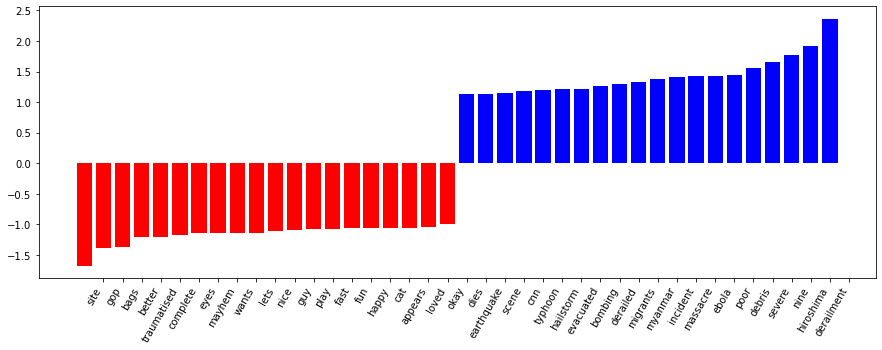

In [83]:
#get the most informative features for classifiers which have the attribute "coef_"
#code from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
import matplotlib.pyplot as plt
def plot_coef_svm(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()


clf_svm = best_parameters['clf'].fit(best_parameters['vect'].fit_transform(X_train).toarray(), y_train)
plot_coef_svm(clf_svm, best_parameters['vect'].get_feature_names())

####5.3.6 CV + RFC

In [84]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1))
    ])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__min_df': np.arange(0.001, 0.003, 0.001),
    'vect__stop_words': (['http','https','www','url','co'],['http','https','www','url','co']+en_stop),
    #'vect__tokenizer': (lambda text: mark_negation(word_tokenize(text)),None), => these variations are removed because all our results were the same: tokenizer=None
    #'vect__lowercase': (False,True), => these variations are removed because all our results were the same: lowercase=TRUE
    #'vect__token_pattern': (r"(?u)\b\w\w+\b|!|\?|\"|\'",r'\b[^\d\W]+\b','(?u)\b\w\w+\b'), => these variations are tricky. Good results with token_pattern=r'\b[^\d\W]+\b' but the csq is that indiv alphabet words are not removed
    # 'vect__max_features': (None, 5000, 10000, 50000), => these variations are removed because all our results were the same : max_features=None
    'vect__ngram_range': ((1, 1), (1, 2),(1,3)),  # unigrams or bigrams or trigrams
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    fitted=grid_search.fit(X_train_list, y_train)
    y_pred_cv_rfc = fitted.predict(X_dev_list)

    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__min_df': array([0.001, 0.002]),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': (['http', 'https', 'www', 'url', 'co'],
                      ['http',
                       'https',
                       'www',
                       'url',
                       'co',
                       "wouldn't",
                       'our',
                       'most',
                       'don',
                       'ain',
                       'me',
                       'doesn',
                       'other',
                       'these',
                       'yours',
                       'do',
                       'have',
                       'ma',
                       'to',
                       'as',
                       'it',
                       'herself',
                       "mustn't",
             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


done in 135.365s

Best score: 0.760
Best parameters set:
	vect__min_df: 0.001
	vect__ngram_range: (1, 2)
	vect__stop_words: ['http', 'https', 'www', 'url', 'co']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.2s finished


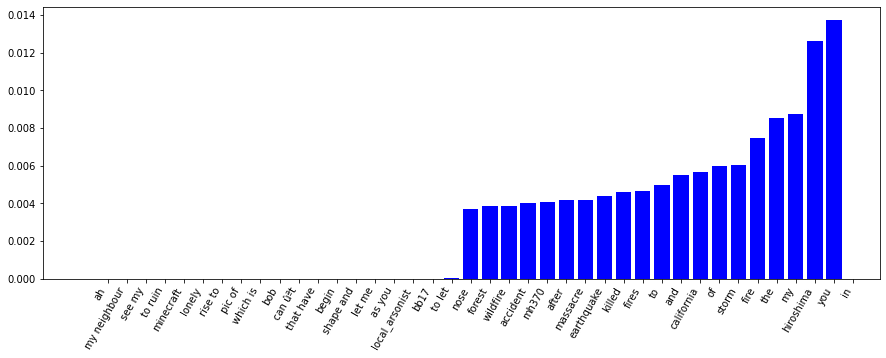

In [85]:
#get the most informative features for classifiers which have the attribute "feature_importances_"
def plot_coef_rfc(classifier, feature_names, top_features=20):
 coef = classifier.feature_importances_
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

clf_rfc=best_parameters['clf'].fit(best_parameters['vect'].fit_transform(X_train), y_train)
plot_coef_rfc(clf_rfc, best_parameters['vect'].get_feature_names())
#we can see some bigrams among the non determinant features

####5.3.6 CV + MNB

In [86]:
from sklearn.naive_bayes import MultinomialNB
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__min_df': np.arange(0.001, 0.003, 0.001),
    'vect__stop_words': (['http','https','www','url','co'],['http','https','www','url','co']+en_stop),
    #'vect__tokenizer': (lambda text: mark_negation(word_tokenize(text)),None), => these variations are removed because all our results were the same: tokenizer=None
    #'vect__lowercase': (False,True), => these variations are removed because all our results were the same: lowercase=TRUE
    #'vect__token_pattern': (r"(?u)\b\w\w+\b|!|\?|\"|\'",r'\b[^\d\W]+\b','(?u)\b\w\w+\b'), => these variations are tricky. Good results with token_pattern=r'\b[^\d\W]+\b' but the csq is that indiv alphabet words are not removed
    # 'vect__max_features': (None, 5000, 10000, 50000), => these variations are removed because all our results were the same : max_features=None
    'vect__ngram_range': ((1, 1), (1, 2),(1,3)),  # unigrams or bigrams or trigrams
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    fitted=grid_search.fit(X_train_list, y_train)
    y_pred_cv_MNB = fitted.predict(X_dev_list)

    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__min_df': array([0.001, 0.002]),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': (['http', 'https', 'www', 'url', 'co'],
                      ['http',
                       'https',
                       'www',
                       'url',
                       'co',
                       "wouldn't",
                       'our',
                       'most',
                       'don',
                       'ain',
                       'me',
                       'doesn',
                       'other',
                       'these',
                       'yours',
                       'do',
                       'have',
                       'ma',
                       'to',
                       'as',
                       'it',
                       'herself',
                       "mustn't",
             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    5.1s remaining:    0.7s


done in 5.609s

Best score: 0.779
Best parameters set:
	vect__min_df: 0.001
	vect__ngram_range: (1, 1)
	vect__stop_words: ['http', 'https', 'www', 'url', 'co']


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.5s finished


####5.3.6 CV + LogisticRegression

In [87]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
   ('clf', LogisticRegression())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__min_df': np.arange(0.001, 0.003, 0.001),
    'vect__stop_words': (['http','https','www','url','co'],['http','https','www','url','co']+en_stop),
    #'vect__tokenizer': (lambda text: mark_negation(word_tokenize(text)),None), => these variations are removed because all our results were the same: tokenizer=None
    #'vect__lowercase': (False,True), => these variations are removed because all our results were the same: lowercase=TRUE
    #'vect__token_pattern': (r"(?u)\b\w\w+\b|!|\?|\"|\'",r'\b[^\d\W]+\b','(?u)\b\w\w+\b'), => these variations are tricky. Good results with token_pattern=r'\b[^\d\W]+\b' but the csq is that indiv alphabet words are not removed
    # 'vect__max_features': (None, 5000, 10000, 50000), => these variations are removed because all our results were the same : max_features=None
    'vect__ngram_range': ((1, 1), (1, 2),(1,3)),  # unigrams or bigrams or trigrams
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    fitted=grid_search.fit(X_train_list, y_train)
    y_pred_cv_LR = fitted.predict(X_dev_list)

    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Automatically created module for IPython interactive environment
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__min_df': array([0.001, 0.002]),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': (['http', 'https', 'www', 'url', 'co'],
                      ['http',
                       'https',
                       'www',
                       'url',
                       'co',
                       "wouldn't",
                       'our',
                       'most',
                       'don',
                       'ain',
                       'me',
                       'doesn',
                       'other',
                       'these',
                       'yours',
                       'do',
                       'have',
                       'ma',
                       'to',
                       'as',
                       'it',
                       'herself',
                       "mustn't",
             

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.0s finished


done in 7.545s

Best score: 0.770
Best parameters set:
	vect__min_df: 0.002
	vect__ngram_range: (1, 3)
	vect__stop_words: ['http', 'https', 'www', 'url', 'co']


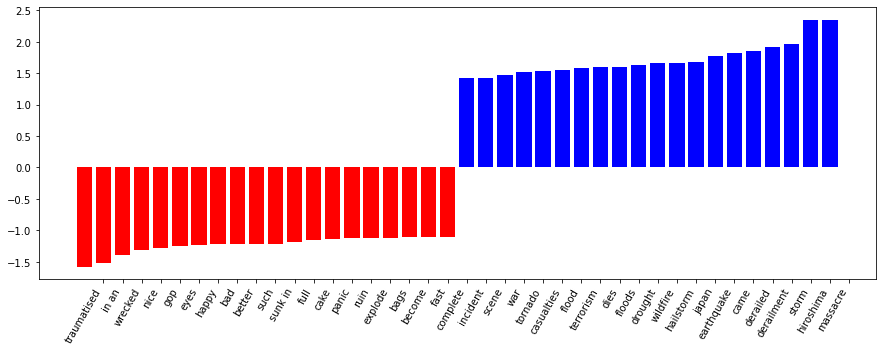

In [88]:
clf_LR=best_parameters['clf'].fit(best_parameters['vect'].fit_transform(X_train_list), y_train)
plot_coef_svm(clf_LR, best_parameters['vect'].get_feature_names())

####5.3.6 CV + Stochastic Gradient Descent

In [89]:
print(__doc__)
from sklearn.linear_model import SGDClassifier
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__min_df': np.arange(0.001, 0.003, 0.001),
    'vect__stop_words': (['http','https','www','url','co'],['http','https','www','url','co']+en_stop),
    #'vect__tokenizer': (lambda text: mark_negation(word_tokenize(text)),None), => these variations are removed because all our results were the same: tokenizer=None
    #'vect__lowercase': (False,True), => these variations are removed because all our results were the same: lowercase=TRUE
    #'vect__token_pattern': (r"(?u)\b\w\w+\b|!|\?|\"|\'",r'\b[^\d\W]+\b','(?u)\b\w\w+\b'), => these variations are tricky. Good results with token_pattern=r'\b[^\d\W]+\b' but the csq is that indiv alphabet words are not removed
    # 'vect__max_features': (None, 5000, 10000, 50000), => these variations are removed because all our results were the same : max_features=None
    'vect__ngram_range': ((1, 1), (1, 2),(1,3)),  # unigrams or bigrams or trigrams
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    fitted=grid_search.fit(X_train_list, y_train)
    y_pred_cv_SGD = fitted.predict(X_dev_list)

    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__min_df': array([0.001, 0.002]),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': (['http', 'https', 'www', 'url', 'co'],
                      ['http',
                       'https',
                       'www',
                       'url',
                       'co',
                       "wouldn't",
                       'our',
                       'most',
                       'don',
                       'ain',
                       'me',
                       'doesn',
                       'other',
                       'these',
                       'yours',
                       'do',
                       'have',
                       'ma',
                       'to',
                       'as',
                       'it',
                       'herself',
                       "mustn't",
             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    5.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.9s finished


done in 6.159s

Best score: 0.738
Best parameters set:
	vect__min_df: 0.002
	vect__ngram_range: (1, 2)
	vect__stop_words: ['http', 'https', 'www', 'url', 'co', "wouldn't", 'our', 'most', 'don', 'ain', 'me', 'doesn', 'other', 'these', 'yours', 'do', 'have', 'ma', 'to', 'as', 'it', 'herself', "mustn't", 'any', 'such', 'that', "she's", 'which', 'here', 'there', 'hadn', 'after', "hadn't", "you've", "couldn't", 'am', 'wouldn', "weren't", "it's", 'needn', 'why', 'myself', 'isn', 'those', 'their', 'weren', 'he', 'be', 'shouldn', 'did', 'm', "wasn't", 'too', 'your', 'then', 'wasn', 'mustn', "should've", 'should', 'the', 'more', 'didn', 'and', 'an', 'him', 'themselves', 'on', "you'd", 'than', "haven't", 'while', 'into', 'out', 'yourselves', "aren't", "you're", 'or', 'its', "you'll", 'nor', "needn't", 'y', 'just', 'aren', 'his', 'during', 'been', 'is', 'were', 'each', "mightn't", 'being', 'you', 'further', 'under', 'had', 'until', 'once', 'o', 've', 'how', 'few', 'she', 'because', 'but', 'so', "

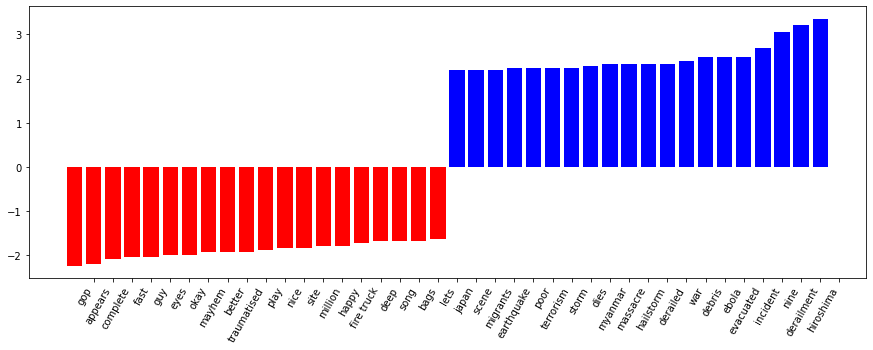

In [90]:
clf_SGD=best_parameters['clf'].fit(best_parameters['vect'].fit_transform(X_train_list), y_train)
plot_coef_svm(clf_SGD, best_parameters['vect'].get_feature_names())
#the list of features is more surprising here because negative words appears to determine target

### 5.3 Vote classic classifiers

We build a classifier which is the result of the vote between our previous classifiers.

In [91]:
from scipy import stats
def votepred(votes):
  m = stats.mode(votes)
  pred=np.ndarray.flatten(m[0])
  conf=np.ndarray.flatten(m[1])/len(votes)
  return pred, conf
y_votes=np.vstack((y_pred_cv_SGD,y_pred_cv_LR,y_pred_cv_MNB,y_pred_cv_rfc,y_pred_cv_svm,y_pred_wvdf_rfc))
print(y_votes.shape)
y_pred_vote=votepred(y_votes)[0]
print(y_pred_vote.shape)

(6, 1306)
(1306,)


In [92]:
#our voted classifier for one tweet
print("classification:",votepred(y_votes[0])[0]," confidence:",votepred(y_votes[0])[1])

classification: [0]  confidence: [0.63323124]


## 6 Quantitative evaluation, first round

Use a function created in TP : an eval function that accept y_true, y_pred as arguments.

It should display multiple quantitative evaluations:
- precision
- recall
- f1-score

*y_true* = the verified labels (from the dataset)
*y_pred* = the predicted labels (by any classifier)

For the ROC curve you need to compute it separtely for each label *y* and then plot it.


Create an other function which will store indicators which are the most important for us: accuracy and recall. Indeed we want to pay attention to recall because we would like to detect all effective desasters at the risk of over-detecting. Above all, we want to avoid leaving effective disasters undetected.

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)

#y_true must be of shape (1523,)
#y_pred must be of shape (1523,)
def show_eval(y_true, y_pred):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  Have to transform our y datasets into  binarized datasets
  '''
  y_true = lb.fit_transform(y_true)
  y_true= np.hstack((1 - y_true,y_true))
  y_pred = lb.fit_transform(y_pred)
  y_pred = np.hstack((1 - y_pred,y_pred))
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = [0, 1]
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(i, label, roc_auc[i], fpr[i], tpr[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+ str(label))
    plt.legend(loc="lower right")
    plt.show()


In [94]:
#verif de la stabilite des features names
print(y_pred_cv_svm[:10,],y_pred_cv_svm.shape)
y_true = lb.fit_transform(y_pred_cv_svm)
print(y_true[:10,],y_true.shape)
y_true= np.hstack((1 - y_true,y_true))
print(y_true[:10,],y_true.shape)
y_true_names = lb_trained.inverse_transform(y_true)
print(y_true_names[:10,],y_true_names.shape)

[0 0 1 1 0 0 0 0 0 0] (1306,)
[[0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]] (1306, 1)
[[1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]] (1306, 2)
[0 0 1 1 0 0 0 0 0 0] (1306,)


In [0]:
def show_acc_and_recall(y_true, y_pred):
  y_true = lb.fit_transform(y_true)
  y_true= np.hstack((1 - y_true,y_true))
  y_pred = lb.fit_transform(y_pred)
  y_pred = np.hstack((1 - y_pred,y_pred))
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  return[round(accuracy_score(y_true_names, y_pred_names)*100,1),round(recall_score(y_true_names, y_pred_names)*100,1)]

2020-04-12 21:55:32,279 INFO NumExpr defaulting to 4 threads.


              precision    recall  f1-score   support

           0       0.57      0.38      0.45       762
           1       0.41      0.60      0.49       544

    accuracy                           0.47      1306
   macro avg       0.49      0.49      0.47      1306
weighted avg       0.50      0.47      0.47      1306



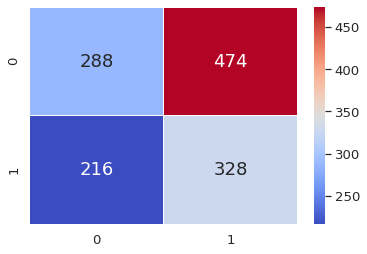

0 0 0.49044696618805006 [0.         0.39705882 1.        ] [0.         0.37795276 1.        ]
1 1 0.49044696618805006 [0.         0.62204724 1.        ] [0.         0.60294118 1.        ]


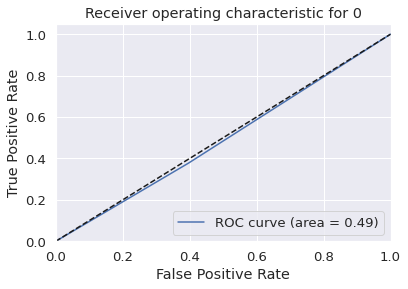

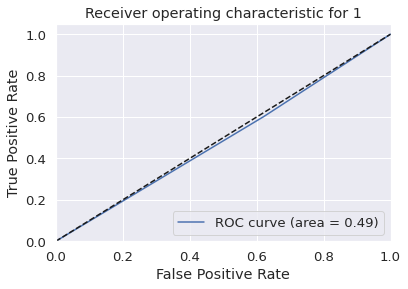

In [96]:
show_eval(y_dev, y_pred_senti)

In [0]:
results_senti=show_acc_and_recall(y_dev, y_pred_senti)

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       762
           1       0.69      0.63      0.66       544

    accuracy                           0.73      1306
   macro avg       0.72      0.71      0.72      1306
weighted avg       0.73      0.73      0.73      1306



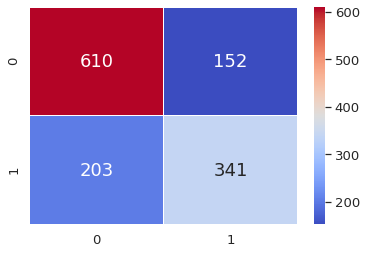

0 0 0.7136815848386598 [0.         0.37316176 1.        ] [0.         0.80052493 1.        ]
1 1 0.71368158483866 [0.         0.19947507 1.        ] [0.         0.62683824 1.        ]


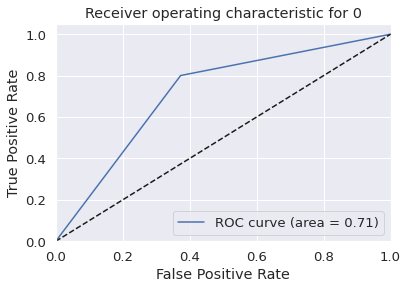

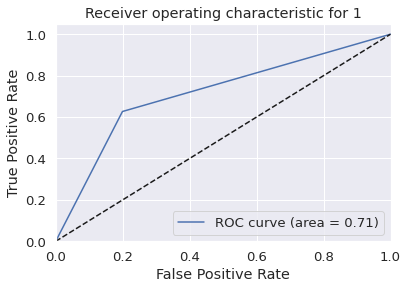

In [98]:
show_eval(y_dev, y_pred_cv_svm)

In [0]:
results_cv_svm=show_acc_and_recall(y_dev, y_pred_cv_svm)

              precision    recall  f1-score   support

           0       0.73      0.88      0.80       762
           1       0.76      0.55      0.64       544

    accuracy                           0.74      1306
   macro avg       0.75      0.71      0.72      1306
weighted avg       0.74      0.74      0.73      1306



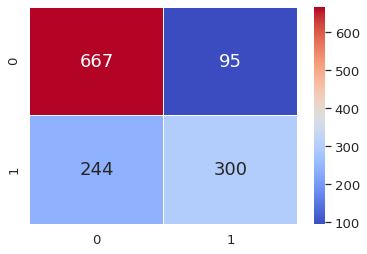

0 0 0.7133993361123977 [0.         0.44852941 1.        ] [0.         0.87532808 1.        ]
1 1 0.7133993361123977 [0.         0.12467192 1.        ] [0.         0.55147059 1.        ]


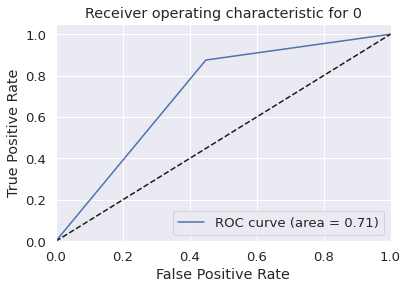

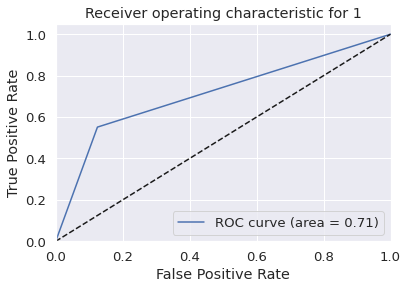

In [100]:
show_eval(y_dev, y_pred_cv_rfc)

In [0]:
results_cv_rfc=show_acc_and_recall(y_dev, y_pred_cv_rfc)

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       762
           1       0.73      0.65      0.69       544

    accuracy                           0.76      1306
   macro avg       0.75      0.74      0.75      1306
weighted avg       0.76      0.76      0.75      1306



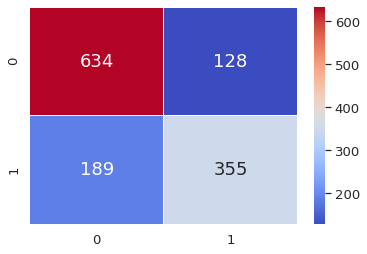

0 0 0.7422972633935464 [0.         0.34742647 1.        ] [0.       0.832021 1.      ]
1 1 0.7422972633935464 [0.       0.167979 1.      ] [0.         0.65257353 1.        ]


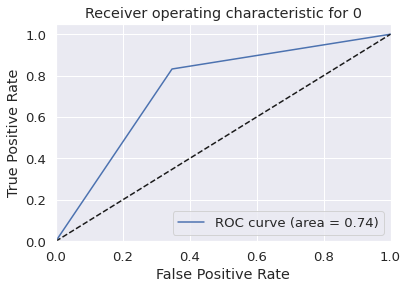

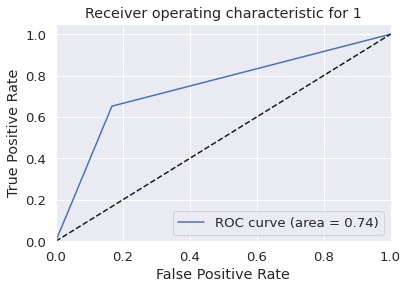

In [102]:
show_eval(y_dev, y_pred_cv_MNB)

In [0]:
results_cv_MNB=show_acc_and_recall(y_dev, y_pred_cv_MNB)

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       762
           1       0.71      0.62      0.67       544

    accuracy                           0.74      1306
   macro avg       0.73      0.72      0.73      1306
weighted avg       0.74      0.74      0.74      1306



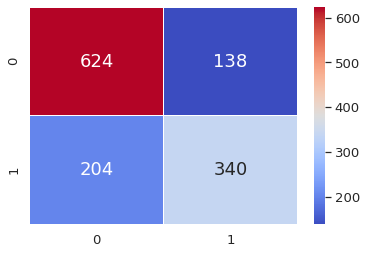

0 0 0.7219488188976377 [0.    0.375 1.   ] [0.         0.81889764 1.        ]
1 1 0.7219488188976378 [0.         0.18110236 1.        ] [0.    0.625 1.   ]


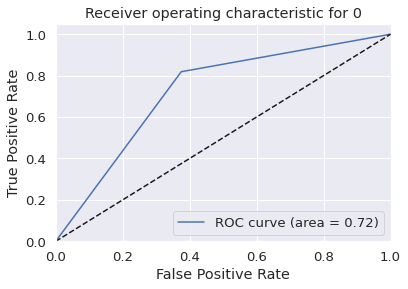

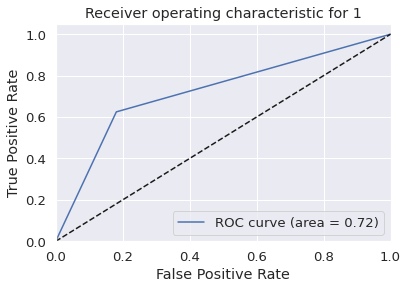

In [104]:
show_eval(y_dev, y_pred_cv_LR)

In [0]:
results_cv_LR=show_acc_and_recall(y_dev, y_pred_cv_LR)

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       762
           1       0.70      0.62      0.65       544

    accuracy                           0.73      1306
   macro avg       0.72      0.71      0.72      1306
weighted avg       0.73      0.73      0.73      1306



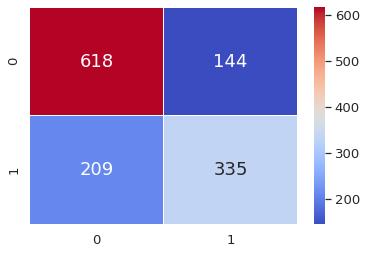

0 0 0.7134162227883278 [0.         0.38419118 1.        ] [0.         0.81102362 1.        ]
1 1 0.7134162227883278 [0.         0.18897638 1.        ] [0.         0.61580882 1.        ]


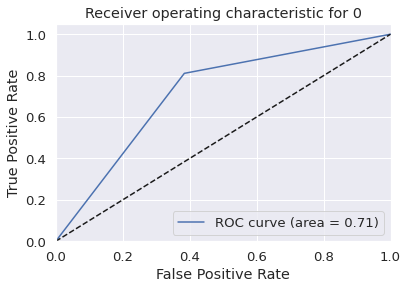

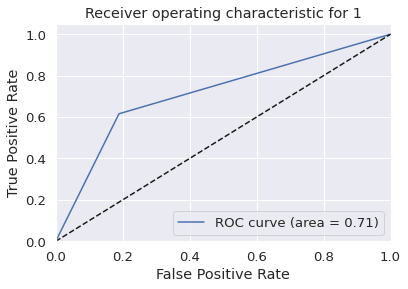

In [106]:
show_eval(y_dev, y_pred_cv_SGD)

In [0]:
results_cv_SGD=show_acc_and_recall(y_dev, y_pred_cv_SGD)

In [0]:
#show_eval(y_dev, y_pred_wvdf_svm)

In [0]:
#results_wvdf_svm=show_acc_and_recall(y_dev, y_pred_wvdf_svm)

              precision    recall  f1-score   support

           0       0.62      0.95      0.75       762
           1       0.70      0.17      0.28       544

    accuracy                           0.62      1306
   macro avg       0.66      0.56      0.51      1306
weighted avg       0.65      0.62      0.55      1306



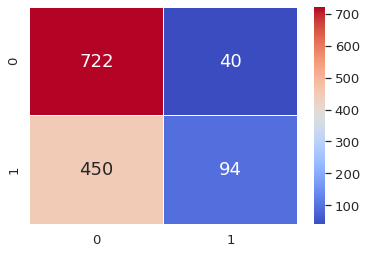

0 0 0.5601503396634244 [0.         0.82720588 1.        ] [0.         0.94750656 1.        ]
1 1 0.5601503396634244 [0.         0.05249344 1.        ] [0.         0.17279412 1.        ]


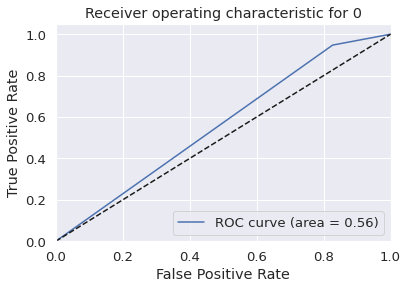

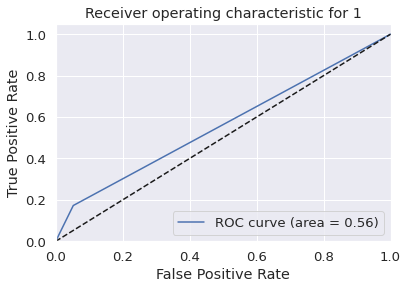

In [110]:
show_eval(y_dev, y_pred_wvdf_rfc)

In [0]:
results_wvdf_rfc=show_acc_and_recall(y_dev, y_pred_wvdf_rfc)

In [0]:
#show_eval(y_dev, y_pred_wvdf_LR)

In [0]:
#results_wvdf_LR=show_acc_and_recall(y_dev, y_pred_wvdf_LR)

In [0]:
#show_eval(y_dev, y_pred_wvdf_SGD)

In [0]:
#results_wvdf_SGD=show_acc_and_recall(y_dev, y_pred_wvdf_SGD)

              precision    recall  f1-score   support

           0       0.73      0.90      0.81       762
           1       0.80      0.54      0.65       544

    accuracy                           0.75      1306
   macro avg       0.77      0.72      0.73      1306
weighted avg       0.76      0.75      0.74      1306



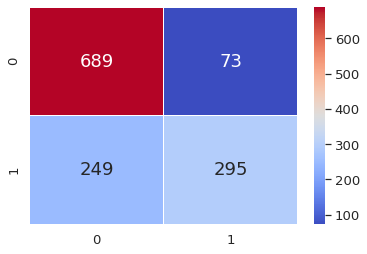

0 0 0.7232394434151612 [0.         0.45772059 1.        ] [0.         0.90419948 1.        ]
1 1 0.7232394434151613 [0.         0.09580052 1.        ] [0.         0.54227941 1.        ]


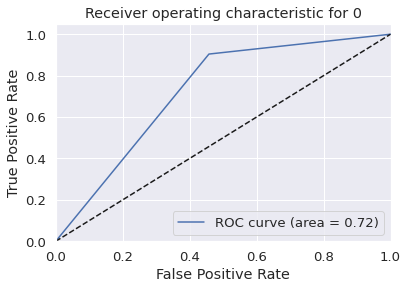

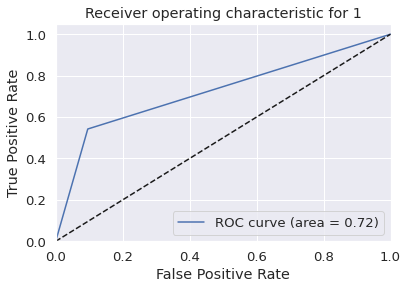

In [116]:
show_eval(y_dev, y_pred_vote)

In [0]:
results_vote=show_acc_and_recall(y_dev, y_pred_vote)

We build a table which gives accuracy and recall of our most interesting simulations

In [118]:
#un tableau donnant l'accuracy et le recall de chaque combinaison
column_names = ['accuracy', 'recall']
row_names= []
embed=['cv','wvdf']
classif_cv=['svm','rfc','MNB','LR','SGD']
classif_wvdf=['rfc']
autre=['senti','vote']
def boucle():
    i=0
    results=np.zeros((len(classif_wvdf)+len(classif_cv)+len(autre),2))
    for s in classif_wvdf:
        exec("results[i,:]=results_wvdf_"+str(s))
        row_names.append(("wvdf",s))
            #print(g,s)
            #print(i)
        i+=1  
    for d in classif_cv:
        exec("results[i,:]=results_cv_"+str(d))
        row_names.append(("cv",d))
        #print(g,s)
       #print(i)
        i+=1 
    for h in autre:
        exec("results[i,:]=results_"+str(h))
        row_names.append((h))
        i+=1 
    results = pd.DataFrame(results, columns=column_names, index=row_names)  
    return results
if __name__=='__main__':
    res=boucle()
    print(res)

             accuracy  recall
(wvdf, rfc)      62.5    17.3
(cv, svm)        72.8    62.7
(cv, rfc)        74.0    55.1
(cv, MNB)        75.7    65.3
(cv, LR)         73.8    62.5
(cv, SGD)        73.0    61.6
senti            47.2    60.3
vote             75.3    54.2


In [119]:
# Access to the drive
%cd /content/drive/My Drive/

from google.colab import drive
drive.mount('/content/drive')

[Errno 2] No such file or directory: '/content/drive/My Drive/'
/content


KeyboardInterrupt: ignored

In [0]:
# to export results table
import os
currPath = '/content/drive/My Drive'    
os.chdir(currPath)

In [0]:
res.to_csv('resultats.csv', mode='a', index=True, sep='&',line_terminator=' \\\\\n')

In [0]:
#at this point the computer may lack memory so we can save our first results and then carry on with deep learning

## 7 Reload, reclean the data and recreate training, dev, and test sets

### 7.1 Load the data

**data** from TP2 containing tweets (can be used to train word embedding algo) :

In [0]:
! wget -O tweets.csv https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv
! wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv

In [0]:
import pandas as pd
dfTweets = pd.read_csv('tweets.csv')
df_pol = pd.read_csv('Political-media-DFE.csv', encoding='latin-1')

data from our project :

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/camduf/mlfornlp/master/train.csv")

In [0]:
df.head()

In [0]:
df.columns

In [0]:
print(df.text.iloc[0], df.target.iloc[0])

In [0]:
df=df.drop(['keyword','location','id'],axis=1)
df.shape

In [0]:
df=df.dropna(axis=0)
df.shape

In [0]:
#the database has "quasi-duplicates" as well (see the cleaning part)
df=df.drop_duplicates()
df.shape

In [0]:
#tweets by category
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
x=df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [0]:
#disastrous teweets seem to be less homogenous in terms of length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
num_words = df[df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(num_words, color='blue')
ax1.set_title('Disaster tweets')

num_words = df[df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(num_words, color='orange')
ax2.set_title('Non disaster tweets')

fig.suptitle('Words in a tweets')
plt.show()

In [0]:
# function to change 0 to irrelevant and 1 to relevant
def transf(x):
    if x==0:
        x="irrelevant"
    elif x==1:
        x="relevant"
    return(x)
df.shape[0]
len(df['text'])

In [0]:
#here we have all the tweets with their category
documents=[]
for i in range(len(df['text'])):
    documents.append((df.text.iloc[0], transf(df.target.iloc[0])))
print(len(documents),type(documents))

In [0]:
documents[1]

### 7.2 Clean the data

The idea is to transform the raw text (= list of tweets) into a list of tokenized tweets. Generally, tokens will be words, but they also may be meaningful punctuation like emoji. It depends on our cleaning functions. The goal is to decrease computational costs by removing unmeaningful tokens. \\

We face a trade-off between parcimony and relevance. Indeed in the case of tweets, and in the particular case of disaster prediction, capital letters, emotive punctuations ("!" for example) can well be meaningful.

#### 7.2.1 Cleaning step by step


In [0]:
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sn
from string import punctuation, digits 
import re

nltk.download('punkt')
nltk.download('stopwords')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

In [0]:
X=df["text"]
y=df["target"]

In [0]:
#tokenisation
tokenizer = TweetTokenizer()
all_words=[]
all_words = ' '.join(X)
len(all_words)
text_pre= tokenizer.tokenize(all_words)

In [0]:
#at each step, this function shows the effect of the cleaning treatment
def treatment(step):
  text_post=step(text_pre)
  all_words_text_pre=nltk.FreqDist(text_pre)
  all_words_text_post=nltk.FreqDist(text_post)
  all_words_text_post.plot(17)
  print('vocabulary length pre treatment :', len(all_words_text_pre),'vocabulary length post treatment :', len(all_words_text_post))
  print('corpus length pre treatment :', len(text_pre),'corpus length post treatment :', len(text_post))
  return text_post

In [0]:
#lets remove url
def remove_url(tokens):
  #variante
  #url = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)')
  url = re.compile(r'https?://\S+|www\.\S+|#\w+ ?')
  filtered_url=[]
  for words in tokens:
    word=url.sub(r'',words)
    if len(word)>0:
        filtered_url.append(word.lower())    
  return filtered_url

In [0]:
text_pre=treatment(remove_url)

In [0]:
#translate slang
#inspired from https://github.com/rishabhverma17/sms_slang_translator

import csv
import re

def translator(user_string,slang):
  _str=user_string.lower()
  for index, row in slang.iterrows():
                # Check if selected word matches short forms in text file.
    if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
        user_string = row[1]
    # Return a list of words
  return(user_string.split(" "))

In [0]:
from itertools import chain
def trans_slang(tokens):
  url = "https://raw.githubusercontent.com/camduf/mlfornlp/master/slang.txt"
  slang=pd.read_csv(url, delimiter="=",header=None)
  tokens =list(chain.from_iterable(translator(item,slang) for item in tokens))
  return list(tokens)

In [0]:
#text_pre=treatment(trans_slang)
#works well but takes a long time

In [0]:
#lets remove stop words
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
def remove_stopwords(tokens):
  filtered_sentence=[]
  for w in tokens:
      if w.lower() not in stop_words:
          filtered_sentence.append(w)  
  return filtered_sentence

In [0]:
text_pre=treatment(remove_stopwords)

In [0]:
#lets remove punctuation (digits are in this category)
def remove_punctuation(tokens):
  pct=re.compile(r'[-.,?!:;()|0-9]')
  post_punctuation=[]
  for words in tokens:
      word=pct.sub("",words)
      if len(word)>0:
          post_punctuation.append(word)
  return post_punctuation

In [0]:
text_pre=treatment(remove_punctuation)

In [0]:
#lets remove web signs
def remove_signs_web(tokens):
  sign=re.compile(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)')
  post_sign=[]
  for words in tokens:
      word=sign.sub("",words)
      if len(word)>0:
          post_sign.append(word)
  return post_sign

In [0]:
text_pre=treatment(remove_signs_web)

In [0]:
#lets remove emoji
def remove_emoji(tokens):
  emoji = re.compile("["u"\U0001F600-\U0001F64F"u"\U0001F300-\U0001F5FF"u"\U0001F680-\U0001F6FF"u"\U0001F1E0-\U0001F1FF"u"\U00002702-\U000027B0"u"\U000024C2-\U0001F251""]+", flags=re.UNICODE)
  filtered_emoji=[]
  for words in tokens:
      word=emoji.sub(r'',words)
      if len(word)>0:
          filtered_emoji.append(word)
  return filtered_emoji

In [0]:
text_pre=treatment(remove_emoji)

In [0]:
#lets remove indiv alphabet
def remove_indiv_alpha(tokens):
  post_indiv=[]
  for words in tokens:
      if len(words)!=1:
          post_indiv.append(words)
  return post_indiv

In [0]:
text_pre=treatment(remove_indiv_alpha)

In [0]:
nltk.download('wordnet')
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer

#lets do stemming
##stemming+lowercase
def stemming(tokens):
  post_stem=[]
  word_lem=WordNetLemmatizer()
  for word in tokens:
      post_stem.append(word_lem.lemmatize(word).lower())
  return post_stem

In [0]:
text_pre=treatment(stemming)

In [0]:
#we take the first 5000 as features
all_words=nltk.FreqDist(text_pre)
word_features= list(all_words.keys())[:5000]
word_features

In [0]:
import random 
from nltk.tokenize import word_tokenize
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
word_lem=WordNetLemmatizer()
#find features
def find_features(document):
    tokenizer = TweetTokenizer()
    words=[]
    words1=tokenizer.tokenize(document)
    for word in words1:
        words.append(word_lem.lemmatize(word).lower())
    features={}
    for w in word_features:
        features[w]=(w in words)
    return features

featuresets = [(find_features(rev),category) for (rev,category) in documents]

In [0]:
pd.Series(featuresets[8][0]).value_counts()

#### 7.2.2 Cleaning all steps in one function

In [0]:
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sn
from string import punctuation
from string import digits

nltk.download('punkt')
nltk.download('stopwords')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
en_stop = list(set(nltk.corpus.stopwords.words('english')))

In [0]:
from tqdm import tqdm
#function to tokenize and to clean
#order of tokenization and cleaning matters

def tokenize_url_hashtags_4tweets(corpus):

  tokenizer = TweetTokenizer() 
  
  tokenized_tweets = []
  for sample in tqdm(corpus):
    #sample is a tweet
    tokens = tokenizer.tokenize(sample)
    #tokens is a list of tokens corresponding to a tweet

    ## variants activating one or/and another of these lines :
    #tokens = list(map(lambda x: x.lower(), tokens)) 
    #tokens = trans_slang(tokens)
    tokens = list(map(lambda x: x.lower(), tokens)) 
    tokens = remove_url(tokens)
    tokens = remove_signs_web(tokens)
    tokens = remove_emoji(tokens)
    tokens = remove_punctuation(tokens)
    tokens = stemming(tokens)
    tokens = remove_stopwords(tokens)
    tokens = remove_indiv_alpha(tokens)
    tokenized_tweets.append(tokens)
  return tokenized_tweets

#Camille: ajouter une justification de cet ordre avec un petit test de classification sur des variantes

In [0]:
X_cleaned = tokenize_url_hashtags_4tweets(X.array)
# X_cleaned is a list of lists of tokens
flatten = lambda l: [item for sublist in l for item in sublist]
X_cl_flat=flatten(X_cleaned)
# X_cl_flat is a list of tokens
all_words=nltk.FreqDist(X_cl_flat)
all_words.plot(20)
print('Text length of X_cleaned : ',len(X_cl_flat),'Vocabulary length of X_cleaned : ',len(all_words))

In [0]:
#to get the vocabulary of X_cleaned
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features 
get_word_features(X_cl_flat)

In [0]:
X_cleaned = [' '.join(x) for x in X_cleaned]
#X_cleaned is a list of cleaned tweets
print('--------------Cleaned tweets-------------')
print(len(X_cleaned), X_cleaned[0:15], type(X_cleaned))
print('--------------Tweets before cleaning-------------')
print(len(X.array), X.array[0:15])

In [0]:
X_cleaned[5639]
#this tweet is one of the "quasi-duplicates" evoked earlier

In [0]:
XXy_cleaned=np.vstack((X,X_cleaned,y)).T
XXy_cleaned.shape

In [0]:
#here we want to get rid of "quasi-duplicates" thanks to the cleaning function
df_dup=pd.DataFrame(XXy_cleaned)
df_dup.columns=['text','text_cleaned','target']
df_dup['text_cleaned_tr'] = df_dup['text_cleaned'].str[:25]
df_dup.head()
#the threshold 25 enables to get rid of the twin tweet 'video picking body water rescuer searching hundred migrant mediterran'
#other "quasi-duplicates" may remain though

In [0]:
df_ssdup=df_dup.drop_duplicates(subset=['text_cleaned_tr','target'])
df_ssdup.shape

In [0]:
#to check if the tweet is still repeated
l_idx=[]
for index, row in df_ssdup.iterrows():
  if 'body' in row['text_cleaned_tr']:
    l_idx.append(index)

In [0]:
X=df_ssdup["text"]
y=df_ssdup["target"]
#X and y are not cleaned yet, they are just without "quasi-duplicates"
#But our cleaning function is ready to be applied just after

### 7.3 Create training, dev and test sets

We slit the dataset into 3 sets:
- Training set: **60%**: used to train the classifier and obtain a model
- Dev set: **20%**: used to apply the model and check performance while tuning it
- Test set: **20%** used as the final performance check to see if the generalization is ok

Suggested convenient class: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [0]:
from sklearn.model_selection import train_test_split
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)

In [0]:
print(X_train.shape,y_train.shape)
print(X_train.head(),y_train.head())

In [0]:
# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)
print(X_dev.shape,y_dev.shape)
print(X_dev.head(),y_dev.head())

In [0]:
# we apply our cleaning function to all the datasets
X_train_cleaned = tokenize_url_hashtags_4tweets(X_train.array)
X_train_cleaned = [' '.join(x) for x in X_train_cleaned]
X_dev_cleaned = tokenize_url_hashtags_4tweets(X_dev.array)
X_dev_cleaned = [' '.join(x) for x in X_dev_cleaned]
X_test_cleaned = tokenize_url_hashtags_4tweets(X_test.array)
X_test_cleaned = [' '.join(x) for x in X_test_cleaned]
#these are the cleaned databases that we will use after
#with countvectorizer or tfidf veectorizer, we may use raw data because they offer cleaning options

In [0]:
y_train=y_train.tolist()
y_dev=y_dev.tolist()
y_test=y_test.tolist()

## 8 Classify with Deep Learning classifiers

### 8.1 Using Elmo + NN

**Elmo + NN**
inspired from : https://towardsdatascience.com/transfer-learning-using-elmo-embedding-c4a7e415103c
and :  https://towardsdatascience.com/elmo-contextual-language-embedding-335de2268604

A Bidirectional language model is used to compute ELMO. The embedding is now a layer of the neural network, it interacts with the classifier's training.

The specificity of this model : each token is not represented by only 1 vector anymore. Each token in its context is represented by a vector.

In [0]:
import os
!pip install tensorflow==1.14.0
import tensorflow as tf
import tensorflow_hub as hub

!python -m spacy download en_core_web_md #you will need to install this on first load
import spacy
from spacy.lang.en import English
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from IPython.display import HTML
import logging
logging.getLogger('tensorflow').disabled = True #OPTIONAL - to disable outputs from Tensorflow

from sklearn.manifold import TSNE
import seaborn as sns
import re
import gc

In [0]:
#we need to work with tf 1.14
#if it is not the case reinitialize the environment setting
print(tf.__version__)

In [0]:
#import tensorflow as tf
#import tensorflow_hub as hub

url="https://tfhub.dev/google/elmo/2"
embed = hub.Module(url)

#function to perform the pre-trained Elmo embedding on input data
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [0]:
#Elmo embedding on two tweets
#with tweets as inputs
X_train_cleaned = [' '.join(x) for x in X_train_cleaned]
embeddings = embed([X_train_cleaned[1],X_train_cleaned[2]],
signature="default",
as_dict=True)["elmo"]
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embeddings)

In [0]:
message_embeddings.shape

In [0]:
#Elmo embedding on all tweets
embeddings = embed(
X_train_cleaned,
signature="default",
as_dict=True)["elmo"]
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embeddings)

In [0]:
message_embeddings.shape[0]

Graphic representation of tweets with pre-trained elmo embedding



In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50) #reduce down to 50 dim
#as an approximation, we will represent each tweet as the average of its tokens vectors
mess_embed_reduced = pca.fit_transform(message_embeddings.mean(axis=1))
from sklearn.manifold import TSNE
mess_embed_reduced = TSNE(n_components=2).fit_transform(mess_embed_reduced) # further reduce to 2 dim using t-SNE

In [0]:
!pip install chart-studio
from chart_studio.plotly import iplot
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
data = [
    go.Scatter(
        x=[i[0] for i in mess_embed_reduced],
        y=[i[1] for i in mess_embed_reduced],
        mode='markers',
        text=list(zip(X_train_cleaned, y_train)),
    marker=dict(
        size=16,
        color = y_train, #set color equal to a variable
        opacity= 0.8,
        colorscale='Viridis',
        showscale=False
    )
    )
]
layout = go.Layout()
layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="Tweets relevant/irrelevant (ELMO embedding)"
)
fig_cluster.show()
#file = plot(fig, filename='Sentence encode.html')
#from google.colab import files
#files.download('Sentence encode.html')

#we see that pre-trained elmo is good at discriminating relevant and irrelevant tweets

Embedding + Classification model

In [0]:
import keras
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.backend import set_session

#function to build a simple feed-forward neural network along with regularization to avoid over-fitting
def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model
model_elmo = build_model()
##this is the summary of our network
print(model_glove.summary())

In [0]:
#to train the NN
with tf.Session() as session:
    set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(np.array(X_train_cleaned), np.array(y_train), epochs=7, batch_size=256, validation_split = 0.2)
    model_elmo.save_weights('./model_elmo_weights.h7')

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()
#the gain in accuracy after le 4th epoch is smaller
#but there is still a gain

In [0]:
#to predict on the dev set
with tf.Session() as session:
    set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo = build_model() 
    model_elmo.load_weights('./model_elmo_weights.h5')
    import time
    t = time.time()
    y_pred_elmo = np.ndarray.flatten(model_elmo.predict(np.array(X_dev_cleaned).reshape(len(X_dev_cleaned),1)))
    #ajout : pas sure
    message_embeddings = session.run(embeddings)
    print("time: ", time.time() - t)
    print(y_pred_elmo)
    

In [0]:
print(message_embeddings[0])

In [0]:
y_pred_elmo01=np.around(y_pred_elmo)

### 6.2 Glove + LSTM

GLOVE is an abbreviation for global vector, the difference beetween the word2vec and the glove model is that in word2vec model we are only considering our local property of our dataset but in this glove model we are considering the global property of our data set. For word2vec we are either predictingthe target word from its context window either predicting the context words from the target word so in a sense we are considering only the local property but in the glove model we are gonna be taking advantage of the whole statistics from dataset by using co-occurrence matrix or simply the count matrix where we are going to increase the count whenever we find one word in the context of the other then we compute probalities and finaly the ratio of two probalities.

In [0]:
import nltk
nltk.download('punkt')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

tweets = list()
lines = df["text"].values.tolist()

for line in lines:
    # tokenize the text
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    words = [word for word in stripped if word.isalpha()]
    tweets.append(words)
    
tweets[0:5]

In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import preprocessing
import keras
import numpy as np

validation_split = 0.2
max_length = 55 # the max length in terms of words of our
                #tweets , if we have more then 55 words 
                #in a tweet then we are going to neglect
                #the words after the 55th word and if we have
                #lesser number then we are going pad 0
##we are using the tokenizer to fit the text
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)
## we just print our vocabulary size(the number of different
##words)and unique tokens
word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))
##the padding ca be done by this line
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
category =  df['target'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
category = category[indices]
##this line is to convert our classes into one hot vectors
##after this line our classes  will no longer be denoted
## as individual integers but we wil indicate them as a 
##vector 
n_values = np.max(category) + 1
Y = np.eye(n_values)[category]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

In [0]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Download the zip file

GLOVE model was invented by a group of stanford researchers and we can actually downlowd this model from the website 

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

Unzip it

In [0]:
!unzip glove*.zip

Get the exact path of where the embedding vectors are extracted using

In [0]:
##the first thing that we do is to create an embedding 
##index then we need to set the embedding dimension in 
##this version of glove model we have hundred dimentional
## vectors so we are taking 100for embedding dimension
embedding_index = {}
embedding_dim = 100
##this is the file which contains the word vectors, we are going
#to read this file and then we will have a dictionnary where the
##keys are the words and the value are the coefficients(the vectors)
f = open('glove.6B.100d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [0]:
##now we are creating our embedding matrix which will be 
#useful while builidng our embedding layer, the way we do is
#to first generate a matrix of zeros then we are just looping
#through our word index 
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    ##this is just a vector representation of a word
    embedding_vector = embedding_index.get(word)
    ##and if the word is not present in our vector 
    ##representation then we are just ignoring this part
    ## so in this case the row of embedding matrix willl just
    ##be zeros otherwise it will be the vector representation
    ##of that words
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers.embeddings import Embedding
##then we are building the embedding layer and the way to
## do is to use this function embedidng of keras and we have
## to pass this parameters, we must make the trainable 
## parameters false because the word embeddings are already 
##present in our file as we are using the glove model here so 
##the main goal is to avoid the training of words vectors, the 
##researchers have laready trained it for us. we have to pass
##the embedding dimension, the weights should be the embedding
##matrix and the input length should be the max length
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

here we are using lstm which is a version of recurrent neural netword and recurrent neural netword are very useful sequence learning and we can interpret the language at the sequence because every sentence is a set of words and the words appear in their definite order si it's a kind of sequence classification problem and recurrent neural networks are greater at that.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM
##now we are going to build the neural network, first we
##have to initiate the sequential model then we need to 
##add the embedding layer which we are not going to train
##then we will add some lstm we are using 32 lstm units 
## we can change the paramaters and see if we can improve 
##the model performance
model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
##here we are adding a dense layer which is just the last layer

model_glove.add(Dense(2, activation='sigmoid'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
##this is the summary of our network
print(model_glove.summary())

In [0]:
from keras.callbacks import ModelCheckpoint
##we are mentionning here some checkpoints just to save the model
##at each step when the validation accuracy increases froms the 
##prevous epoch then we are saving it
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')

In [0]:
from keras.models import load_model
from keras.initializers import Constant
history_glove = model_glove.fit(X_train_pad, y_train, batch_size=32, epochs=15, validation_data=(X_test_pad, y_test), callbacks=[checkpoint], verbose=1)

In [0]:
# Plot results
import matplotlib.pyplot as plt

acc = history_glove.history['accuracy']
val_acc = history_glove.history['val_accuracy']
loss = history_glove.history['loss']
val_loss = history_glove.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Preparation to predict on X_dev

In [0]:
X_dev_cleaned = tokenize_url_hashtags_4tweets(X_dev.array)

In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import preprocessing
import keras
import numpy as np

#validation_split = 0.2
max_length = 55 # the max length in terms of words of our
                #tweets , if we have more then 55 words 
                #in a tweet then we are going to neglect
                #the words after the 55th word and if we have
                #lesser number then we are going pad 0
##we are using the tokenizer to fit the text
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X_dev_cleaned)
sequences = tokenizer_obj.texts_to_sequences(X_dev_cleaned)
## we just print our vocabulary size(the number of different
##words)and unique tokens
word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))
##the padding ca be done by this line
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]

X_dev_pad=lines_pad


In [0]:
#to predict on the dev set
y_pred_glove = np.ndarray.flatten(model_glove.predict(X_dev_pad))
print(y_pred_glove.shape)

In [0]:
y_pred_glove01 = [] 
for i in range(0, len(y_pred_glove)): 
    if i % 2: 
        y_pred_glove01.append(round(y_pred_glove[i]))  
len(y_pred_glove01)

## 9 Quantitative evaluation, second round

Use a function created in TP : an eval function that accept y_true, y_pred as arguments.

It should display multiple quantitative evaluations:
- precision
- recall
- f1-score

*y_true* = the verified labels (from the dataset)
*y_pred* = the predicted labels (by any classifier)

For the ROC curve you need to compute it separtely for each label *y* and then plot it.


Create an other function which will store indicators which are the most important for us: accuracy and recall. Indeed we want to pay attention to recall because we would like to detect all effective desasters at the risk of over-detecting. Above all, we want to avoid leaving effective disasters undetected.

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)

#y_true must be of shape (1523,)
#y_pred must be of shape (1523,)
def show_eval(y_true, y_pred):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  Have to transform our y datasets into  binarized datasets
  '''
  y_true = lb.fit_transform(y_true)
  y_true= np.hstack((1 - y_true,y_true))
  y_pred = lb.fit_transform(y_pred)
  y_pred = np.hstack((1 - y_pred,y_pred))
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = [0, 1]
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(i, label, roc_auc[i], fpr[i], tpr[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+ str(label))
    plt.legend(loc="lower right")
    plt.show()


In [0]:
#verif de la stabilite des features names
print(y_pred_cv_svm[:10,],y_pred_cv_svm.shape)
y_true = lb.fit_transform(y_pred_cv_svm)
print(y_true[:10,],y_true.shape)
y_true= np.hstack((1 - y_true,y_true))
print(y_true[:10,],y_true.shape)
y_true_names = lb_trained.inverse_transform(y_true)
print(y_true_names[:10,],y_true_names.shape)

In [0]:
def show_acc_and_recall(y_true, y_pred):
  y_true = lb.fit_transform(y_true)
  y_true= np.hstack((1 - y_true,y_true))
  y_pred = lb.fit_transform(y_pred)
  y_pred = np.hstack((1 - y_pred,y_pred))
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  return[round(accuracy_score(y_true_names, y_pred_names)*100,1),round(recall_score(y_true_names, y_pred_names)*100,1)]

In [0]:
results_glove=show_acc_and_recall(y_dev, y_pred_glove01)
results_glove

In [0]:
results_elmo=show_acc_and_recall(y_dev, y_pred_elmo01)
results_elmo

We build a table which gives accuracy and recall of our most interesting simulations

In [0]:
#un tableau donnant l'accuracy et le recall de chaque combinaison
column_names = ['accuracy', 'recall']
row_names= []
embed=[]
classif_cv=[]
classif_wvdf=[]
autre=['elmo','glove']
def boucle():
    i=0
    results=np.zeros((len(embed)*len(classif)+len(autre),2))
    for g in embed:
        for s in exec("classif"+str(g)) :
            exec("results[i,:]=results_"+str(g)+"_"+str(s))
            row_names.append((g,s))
            #print(g,s)
            #print(i)
            i+=1  
    for h in autre:
            exec("results[i,:]=results_"+str(h))
            row_names.append((h))
            i+=1 
    results = pd.DataFrame(results, columns=column_names, index=row_names)  
    return results
if __name__=='__main__':
    res=boucle()
    print(res)

In [0]:
# Access to the drive
%cd /content/drive/My Drive/

from google.colab import drive
drive.mount('/content/drive')

In [0]:
# to export results table
import os
currPath = '/content/drive/My Drive'    
os.chdir(currPath)

In [0]:
res.to_csv('resultats_DL.csv', mode='a', index=True, sep='&',line_terminator=' \\\\\n')

In [0]:
#at this point the computer may lack memory so we can save our first results and then carry on with deep learning

## 10 Qualitative evaluation

In [0]:
import random
#to see more of the 3rd column :
#pd.set_option('display.max_colwidth', -1)
def show_wrong_pred(y_true, y_pred,X):
  column_names = ['true', 'pred', 'tweet']
  X_array=np.array(X)
  y_true_array=np.array(y_true)
  y_pred_array=np.array(y_pred)
  l_wrong=[idx for idx,e in enumerate(y_true)  if e!= y_pred[idx] ]
  X_wrong_pred=np.column_stack((y_true_array[l_wrong],y_pred_array[l_wrong],X_array[l_wrong]))
  X_wrong_pred_show=X_wrong_pred
  np.random.shuffle(X_wrong_pred_show)
  X_wrong_pred_show = pd.DataFrame(X_wrong_pred_show, columns=column_names) 
  l_FP=[idx for idx,e in enumerate(y_true)  if (e==0 and y_pred[idx]==1) ]
  X_FP_pred=np.column_stack((y_true_array[l_FP],y_pred_array[l_FP],X_array[l_FP]))
  X_FP_pred_show=X_FP_pred
  np.random.shuffle(X_FP_pred_show)
  X_FP_pred_show = pd.DataFrame(X_FP_pred_show, columns=column_names) 
  l_FN=[idx for idx,e in enumerate(y_true)  if e==1 and y_pred[idx]==0 ]
  X_FN_pred=np.column_stack((y_true_array[l_FN],y_pred_array[l_FN],X_array[l_FN]))
  X_FN_pred_show=X_FN_pred
  np.random.shuffle(X_FN_pred_show)
  X_FN_pred_show = pd.DataFrame(X_FN_pred_show, columns=column_names) 
  print(X_wrong_pred_show[:15])
  print(X_FP_pred_show[:15])
  print(X_FN_pred_show[:15])
  return X_wrong_pred,X_FP_pred,X_FN_pred

In [0]:
X_dev_wrong_pred,X_dev_FP_pred,X_dev_FN_pred=show_wrong_pred(y_dev,y_pred_vote,X_dev)

In [0]:
X_dev_wrong_pred,X_dev_FP_pred,X_dev_FN_pred=show_wrong_pred(y_dev,y_pred_elmo,X_dev)

In [0]:
#we expect that elmo will classify better non disastrous tweets with the word 'fire' in it for example

## 11 Final results on test bases

Ideally, we would have to run our favorite models on our test databases